# General Evaluation: All Models (Deep Learning + Traditional ML)

This notebook provides comprehensive evaluation and comparison of all models for both beat and rhythm classification tasks.

## Contents
1. **Beat Classification Evaluation**: Compare CNN, LSTM, XGBoost, RandomForest, LogisticRegression
2. **Rhythm Classification Evaluation**: Compare CNN, LSTM, XGBoost, RandomForest, LogisticRegression
3. **Metrics Comparison**: Comprehensive metrics tables for all models
4. **Visualizations**: Sample inputs/outputs, ROC curves, PR curves
5. **Summary Table**: Overall performance comparison of all models

## Models Compared
- **Deep Learning Models**:
  - **CNN**: Lightweight 1D-CNN
  - **LSTM**: Lightweight LSTM
- **Traditional ML Models**:
  - **XGBoost**: Gradient boosting classifier
  - **RandomForest**: Random forest classifier
  - **LogisticRegression**: Logistic regression classifier


In [56]:
# Import libraries
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import label_binarize

from preprocess import (
    load_all_cases, create_sequence_dataset,
    BEAT_LABELS, RHYTHM_LABELS
)
from feature_extractor import extract_hrv_features

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

# Setup save directories
current_dir = os.getcwd()
if current_dir.endswith('notebooks') or current_dir.endswith('notebooks/'):
    base_dir = os.path.dirname(current_dir)
elif 'arrdb' in current_dir:
    parts = current_dir.split(os.sep)
    if 'arrdb' in parts:
        arrdb_idx = parts.index('arrdb')
        base_dir = os.sep.join(parts[:arrdb_idx + 1])
    else:
        base_dir = current_dir
else:
    base_dir = os.path.dirname(os.path.dirname(current_dir))

# Create directories
metrics_dir = os.path.join(base_dir, 'experiments', 'results', 'metrics')
plots_dir = os.path.join(base_dir, 'experiments', 'results', 'plots')
os.makedirs(metrics_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

# Helper function to save figures
def save_and_show(fig, filename, dpi=300):
    """Save figure and then show it."""
    fig_path = os.path.join(plots_dir, filename)
    fig.savefig(fig_path, dpi=dpi, bbox_inches='tight')
    print(f"💾 Saved figure to: {fig_path}")
    plt.show()

print("✅ Libraries imported successfully!")
print(f"📁 Metrics will be saved to: {metrics_dir}")
print(f"📁 Figures will be saved to: {plots_dir}")


✅ Libraries imported successfully!
📁 Metrics will be saved to: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/metrics
📁 Figures will be saved to: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/plots


## Section 1: Load Predictions

Load saved predictions from both CNN and LSTM models for beat and rhythm classification.


In [57]:
# Helper function to find prediction files
def find_prediction_file(filename):
    """Find prediction file in multiple possible locations."""
    current_dir = os.getcwd()
    possible_paths = [
        os.path.join(current_dir, 'experiments', 'results', 'predictions', filename),
        os.path.join(current_dir, '..', 'experiments', 'results', 'predictions', filename),
        os.path.join(current_dir, 'arrdb', 'experiments', 'results', 'predictions', filename),
        os.path.abspath(os.path.join('..', 'experiments', 'results', 'predictions', filename)),
    ]
    
    # Also try absolute path from project root
    if 'Vital_sign_Dataset' in current_dir:
        parts = current_dir.split(os.sep)
        arrdb_idx = parts.index('arrdb') if 'arrdb' in parts else -1
        if arrdb_idx >= 0:
            base_dir = os.sep.join(parts[:parts.index('Vital_sign_Dataset') + 1])
            possible_paths.append(os.path.join(base_dir, 'Vital_sign_Dataset', 'arrdb', 'experiments', 'results', 'predictions', filename))
    elif 'arrdb' in current_dir:
        parts = current_dir.split(os.sep)
        if 'arrdb' in parts:
            arrdb_idx = parts.index('arrdb')
            base_dir = os.sep.join(parts[:arrdb_idx + 1])
            possible_paths.append(os.path.join(base_dir, 'experiments', 'results', 'predictions', filename))
    
    for path in possible_paths:
        if os.path.exists(path):
            return path
    return None

# Load all predictions (DL and ML models)
print("📂 Loading predictions...")

# Deep Learning models
beat_cnn_path = find_prediction_file('beat_classification_predictions.pkl')
beat_lstm_path = find_prediction_file('beat_classification_lstm_predictions.pkl')
rhythm_cnn_path = find_prediction_file('rhythm_classification_predictions.pkl')
rhythm_lstm_path = find_prediction_file('rhythm_classification_lstm_predictions.pkl')

# ML models - load saved predictions and trained models for generating predictions
beat_ml_path = find_prediction_file('beat_classification_ml_predictions.pkl')
rhythm_ml_path = find_prediction_file('rhythm_classification_ml_predictions.pkl')

# Load beat predictions
beat_cnn_predictions = None
beat_lstm_predictions = None
beat_ml_predictions = {}  # Dictionary to store all ML model predictions

if beat_cnn_path and os.path.exists(beat_cnn_path):
    with open(beat_cnn_path, 'rb') as f:
        beat_cnn_predictions = pickle.load(f)
    print(f"✅ Loaded CNN beat predictions from: {beat_cnn_path}")
else:
    print(f"⚠️  CNN beat predictions not found. Please run beat_dl.ipynb first.")

if beat_lstm_path and os.path.exists(beat_lstm_path):
    with open(beat_lstm_path, 'rb') as f:
        beat_lstm_predictions = pickle.load(f)
    print(f"✅ Loaded LSTM beat predictions from: {beat_lstm_path}")
else:
    print(f"⚠️  LSTM beat predictions not found. Please run beat_lstm.ipynb first.")

# Load saved ML predictions if available
if beat_ml_path and os.path.exists(beat_ml_path):
    with open(beat_ml_path, 'rb') as f:
        saved_pred = pickle.load(f)
    ml_model_name = saved_pred.get('model_name', 'ML Model')
    beat_ml_predictions[ml_model_name] = saved_pred
    print(f"✅ Loaded {ml_model_name} beat predictions from: {beat_ml_path}")

# Load rhythm predictions
rhythm_cnn_predictions = None
rhythm_lstm_predictions = None
rhythm_ml_predictions = {}  # Dictionary to store all ML model predictions

if rhythm_cnn_path and os.path.exists(rhythm_cnn_path):
    with open(rhythm_cnn_path, 'rb') as f:
        rhythm_cnn_predictions = pickle.load(f)
    print(f"✅ Loaded CNN rhythm predictions from: {rhythm_cnn_path}")
else:
    print(f"⚠️  CNN rhythm predictions not found. Please run rhythm_dl.ipynb first.")

if rhythm_lstm_path and os.path.exists(rhythm_lstm_path):
    with open(rhythm_lstm_path, 'rb') as f:
        rhythm_lstm_predictions = pickle.load(f)
    print(f"✅ Loaded LSTM rhythm predictions from: {rhythm_lstm_path}")
else:
    print(f"⚠️  LSTM rhythm predictions not found. Please run rhythm_lstm.ipynb first.")

# Load saved ML predictions if available
if rhythm_ml_path and os.path.exists(rhythm_ml_path):
    with open(rhythm_ml_path, 'rb') as f:
        saved_pred = pickle.load(f)
    ml_model_name = saved_pred.get('model_name', 'ML Model')
    rhythm_ml_predictions[ml_model_name] = saved_pred
    print(f"✅ Loaded {ml_model_name} rhythm predictions from: {rhythm_ml_path}")

# Load trained ML models and generate predictions for RandomForest and LogisticRegression
import joblib
from sklearn.preprocessing import StandardScaler

print("\n📂 Loading trained ML models and generating predictions for all ML models...")

# Helper to regenerate test data for ML models
# NOTE: This should match exactly with trad_ml.ipynb preprocessing
# For best results, ensure trad_ml.ipynb saves X_test in prediction files
def regenerate_test_data(task_name, reference_labels=None):
    """Regenerate test data using same preprocessing as trad_ml.ipynb.
    
    Args:
        task_name: 'beat' or 'rhythm'
        reference_labels: Optional array of labels to match length/alignment
    """
    try:
        # Load data
        annotations_dict, metadata_df = load_all_cases()
        
        # Create sequences (same as trad_ml.ipynb)
        if task_name == 'beat':
            sequences, labels, patient_ids = create_sequence_dataset(
                annotations_dict, metadata_df, window_size=60, stride=30, task='beat'
            )
        else:
            sequences, labels, patient_ids = create_sequence_dataset(
                annotations_dict, metadata_df, window_size=60, stride=30, task='rhythm'
            )
        
        # Extract HRV features from windows
        features_list = []
        for i, window_rr in enumerate(sequences):
            hrv_feat = extract_hrv_features(window_rr)
            features_list.append(hrv_feat)
        
        features_df = pd.DataFrame(features_list)
        
        # Select only numeric columns (HRV features)
        numeric_cols = features_df.select_dtypes(include=[np.number]).columns
        features_df = features_df[numeric_cols]
        
        # Get patient splits (same as trad_ml.ipynb: 60/20/20, random_state=42)
        unique_patients = np.unique(patient_ids)
        np.random.seed(42)
        np.random.shuffle(unique_patients)
        n_train = int(0.6 * len(unique_patients))
        n_val = int(0.2 * len(unique_patients))
        
        train_patients = set(unique_patients[:n_train])
        val_patients = set(unique_patients[n_train:n_train+n_val])
        test_patients = set(unique_patients[n_train+n_val:])
        
        # Filter windows by patient splits
        train_mask = np.array([pid in train_patients for pid in patient_ids])
        test_mask = np.array([pid in test_patients for pid in patient_ids])
        
        # Apply StandardScaler (fit on train, transform test)
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        
        X_train = features_df[train_mask].values
        X_test = features_df[test_mask].values
        y_test = np.array(labels)[test_mask]
        
        # Fit scaler on training data and transform test data
        scaler.fit(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # If reference_labels provided, ensure alignment
        if reference_labels is not None:
            ref_len = len(reference_labels)
            if len(X_test_scaled) != ref_len:
                print(f"   ⚠️  Regenerated test data ({len(X_test_scaled)}) doesn't match reference ({ref_len})")
                # Return what we have - alignment will be handled in load_ml_model_predictions
                
        return X_test_scaled, y_test
    except Exception as e:
        print(f"   ⚠️  Error regenerating test data for {task_name}: {str(e)[:100]}")
        import traceback
        traceback.print_exc()
        return None, None

# Helper to find and load model predictions
def load_ml_model_predictions(task_name, model_type):
    """Try to load model and generate predictions."""
    base_name = f'{task_name}_classification_{model_type.lower()}'
    model_path = find_prediction_file(f'{base_name}_model.pkl')
    encoder_path = find_prediction_file(f'{base_name}_encoder.pkl')
    
    if not model_path or not encoder_path:
        return None
    
    try:
        model = joblib.load(model_path)
        label_encoder = joblib.load(encoder_path)
        
        # Get test data and true labels from saved predictions (most reliable source)
        saved_pred_path = find_prediction_file(f'{task_name}_classification_ml_predictions.pkl')
        X_test = None
        test_true_str = None
        
        if saved_pred_path and os.path.exists(saved_pred_path):
            with open(saved_pred_path, 'rb') as f:
                saved_pred = pickle.load(f)
            
            # Get true labels first (these are the ground truth we need to match)
            test_true_str = saved_pred.get('test_true_str')
            
            # Try to get X_test from saved predictions
            if 'X_test' in saved_pred:
                X_test = saved_pred['X_test']
        
        # If X_test not in saved predictions, regenerate it
        # But we MUST use the same test_true_str from saved predictions to ensure alignment
        if X_test is None:
            print(f"   🔄 Regenerating test data for {model_type} ({task_name})...")
            
            # Use saved test_true_str as reference for alignment if available
            X_test_regenerated, y_test_regenerated = regenerate_test_data(
                task_name, 
                reference_labels=test_true_str
            )
            
            if X_test_regenerated is not None:
                X_test = X_test_regenerated
                
                # If we have saved test_true_str, use it (it's the ground truth)
                # Otherwise, use regenerated labels
                if test_true_str is None and y_test_regenerated is not None:
                    try:
                        if hasattr(label_encoder, 'inverse_transform'):
                            test_true_str = label_encoder.inverse_transform(y_test_regenerated)
                        else:
                            test_true_str = y_test_regenerated
                    except:
                        test_true_str = y_test_regenerated
        
        if X_test is None:
            print(f"   ⚠️  Could not get test data for {model_type} ({task_name})")
            return None
        
        if test_true_str is None:
            print(f"   ⚠️  Could not get test labels for {model_type} ({task_name})")
            return None
        
        # Ensure test_true_str is a numpy array or list for length checking
        test_true_str = np.array(test_true_str) if not isinstance(test_true_str, np.ndarray) else test_true_str
        
        # Check alignment - ensure X_test and test_true_str have same length
        if len(X_test) != len(test_true_str):
            print(f"   ⚠️  Mismatch: X_test has {len(X_test)} samples, test_true_str has {len(test_true_str)} samples")
            print(f"   🔧 Attempting to align by using minimum length...")
            min_len = min(len(X_test), len(test_true_str))
            X_test = X_test[:min_len]
            test_true_str = test_true_str[:min_len]
        
        # Generate predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
        
        # Ensure predictions match length
        if len(y_pred) != len(test_true_str):
            print(f"   ⚠️  Prediction length ({len(y_pred)}) doesn't match label length ({len(test_true_str)})")
            return None
        
        # Decode predictions
        if hasattr(label_encoder, 'inverse_transform'):
            y_pred_str = label_encoder.inverse_transform(y_pred)
        else:
            y_pred_str = y_pred
        
        # Final length check
        if len(y_pred_str) != len(test_true_str):
            print(f"   ⚠️  Final length mismatch: predictions={len(y_pred_str)}, labels={len(test_true_str)}")
            return None
        
        return {
            'test_true_str': test_true_str,
            'test_pred_str': y_pred_str,
            'test_proba': y_pred_proba,
            'label_encoder': label_encoder,
            'model_name': model_type
        }
    except Exception as e:
        print(f"   ⚠️  Could not generate predictions for {model_type} ({task_name}): {str(e)[:100]}")
        import traceback
        traceback.print_exc()
    
    return None

# Load all ML models for beat classification
beat_ml_models = ['XGBoost', 'RandomForest', 'LogisticRegression']
for model_name in beat_ml_models:
    preds = load_ml_model_predictions('beat', model_name)
    if preds:
        beat_ml_predictions[model_name] = preds
        print(f"   ✅ Generated predictions for {model_name} (beat classification)")

# Load all ML models for rhythm classification
rhythm_ml_models = ['XGBoost', 'RandomForest', 'LogisticRegression']
for model_name in rhythm_ml_models:
    preds = load_ml_model_predictions('rhythm', model_name)
    if preds:
        rhythm_ml_predictions[model_name] = preds
        print(f"   ✅ Generated predictions for {model_name} (rhythm classification)")

if len(beat_ml_predictions) == 0 and len(rhythm_ml_predictions) == 0:
    print("\n   ⚠️  Note: Could not generate predictions for additional ML models.")
    print("       Make sure trad_ml.ipynb has been run to save trained models.")
else:
    print(f"\n   ✅ Loaded {len(beat_ml_predictions)} beat ML models and {len(rhythm_ml_predictions)} rhythm ML models")

print("\n✅ Prediction loading complete!")


📂 Loading predictions...
✅ Loaded CNN beat predictions from: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/notebooks/../experiments/results/predictions/beat_classification_predictions.pkl
✅ Loaded LSTM beat predictions from: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/notebooks/../experiments/results/predictions/beat_classification_lstm_predictions.pkl
✅ Loaded XGBoost beat predictions from: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/notebooks/../experiments/results/predictions/beat_classification_ml_predictions.pkl
✅ Loaded CNN rhythm predictions from: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/notebooks/../experiments/results/predictions/rhythm_classification_predictions.pkl
✅ Loaded LSTM rhythm predictions from: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/notebooks/../experiments/results/predictions/rhythm_classification_lstm_predictions.pkl
✅ Loaded LogisticRegression rhythm predictions from: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/notebooks/../exp

## Section 2: Beat Classification - Metrics Comparison

Calculate comprehensive metrics for both CNN and LSTM models and create comparison tables.


In [58]:
# Function to calculate comprehensive metrics
def calculate_all_metrics(y_true_str, y_pred_str, y_proba, label_encoder, model_name):
    """Calculate all metrics for a model."""
    # Basic metrics
    accuracy = accuracy_score(y_true_str, y_pred_str)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true_str, y_pred_str, labels=label_encoder.classes_, zero_division=0, average=None
    )
    
    # Macro averages
    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1)
    
    # Weighted averages
    precision_weighted = precision_recall_fscore_support(
        y_true_str, y_pred_str, labels=label_encoder.classes_, zero_division=0, average='weighted'
    )[0]
    recall_weighted = precision_recall_fscore_support(
        y_true_str, y_pred_str, labels=label_encoder.classes_, zero_division=0, average='weighted'
    )[1]
    f1_weighted = precision_recall_fscore_support(
        y_true_str, y_pred_str, labels=label_encoder.classes_, zero_division=0, average='weighted'
    )[2]
    
    # AUROC - only use classes that appear in test set
    try:
        # Get classes that actually appear in test data
        classes_in_test = sorted(list(set(y_true_str)))
        # Filter to only classes that are in label_encoder (trained classes)
        classes_to_use = [c for c in label_encoder.classes_ if c in classes_in_test]
        
        if len(classes_to_use) < 2:
            auroc = np.nan
        else:
            # Binarize using only classes that appear in test
            y_true_binary = label_binarize(y_true_str, classes=classes_to_use)
            
            # Align probability matrix: y_proba columns correspond to label_encoder.classes_
            # Map to classes_to_use
            proba_aligned = np.zeros((len(y_true_str), len(classes_to_use)))
            for i, cls in enumerate(classes_to_use):
                if cls in label_encoder.classes_:
                    idx_in_encoder = list(label_encoder.classes_).index(cls)
                    if idx_in_encoder < y_proba.shape[1]:
                        proba_aligned[:, i] = y_proba[:, idx_in_encoder]
            
            # Only calculate for classes with positive samples
            has_positive = np.sum(y_true_binary, axis=0) > 0
            if np.sum(has_positive) < 2:
                auroc = np.nan
            else:
                # Calculate ROC-AUC per class (only for classes with positive samples)
                roc_auc_per_class = []
                for i in range(len(classes_to_use)):
                    if has_positive[i]:
                        try:
                            auc_score = roc_auc_score(y_true_binary[:, i], proba_aligned[:, i])
                            if not np.isnan(auc_score):
                                roc_auc_per_class.append(auc_score)
                        except:
                            pass
                
                if len(roc_auc_per_class) > 0:
                    auroc = np.mean(roc_auc_per_class)  # Macro average
                else:
                    auroc = np.nan
    except Exception as e:
        import traceback
        traceback.print_exc()
        auroc = np.nan
    
    # AUPRC - same alignment logic
    try:
        # Get classes that actually appear in test data
        classes_in_test = sorted(list(set(y_true_str)))
        # Filter to only classes that are in label_encoder (trained classes)
        classes_to_use = [c for c in label_encoder.classes_ if c in classes_in_test]
        
        if len(classes_to_use) < 2:
            auprc = np.nan
        else:
            # Binarize using only classes that appear in test
            y_true_binary = label_binarize(y_true_str, classes=classes_to_use)
            
            # Align probability matrix
            proba_aligned = np.zeros((len(y_true_str), len(classes_to_use)))
            for i, cls in enumerate(classes_to_use):
                if cls in label_encoder.classes_:
                    idx_in_encoder = list(label_encoder.classes_).index(cls)
                    if idx_in_encoder < y_proba.shape[1]:
                        proba_aligned[:, i] = y_proba[:, idx_in_encoder]
            
            # Calculate AUPRC per class (only for classes with positive samples)
            auprc_per_class = []
            for i in range(len(classes_to_use)):
                if np.sum(y_true_binary[:, i]) > 0:  # Has positive samples
                    try:
                        ap = average_precision_score(y_true_binary[:, i], proba_aligned[:, i])
                        if not np.isnan(ap):
                            auprc_per_class.append(ap)
                    except:
                        pass
            
            if len(auprc_per_class) > 0:
                auprc = np.mean(auprc_per_class)  # Macro average
            else:
                auprc = np.nan
    except Exception as e:
        import traceback
        traceback.print_exc()
        auprc = np.nan
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'auroc': auroc,
        'auprc': auprc,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1,
        'support': support
    }

# Calculate metrics for beat classification (all models)
print("📊 Calculating beat classification metrics...")
print("=" * 70)

beat_metrics = {}

if beat_cnn_predictions:
    cnn_metrics = calculate_all_metrics(
        beat_cnn_predictions['test_true_str'],
        beat_cnn_predictions['test_pred_str'],
        beat_cnn_predictions['test_proba'],
        beat_cnn_predictions['label_encoder'],
        'CNN'
    )
    beat_metrics['CNN'] = cnn_metrics
    print(f"\n✅ CNN Metrics calculated:")
    print(f"   Accuracy: {cnn_metrics['accuracy']:.4f}")
    print(f"   F1-Macro: {cnn_metrics['f1_macro']:.4f}")
    print(f"   AUROC: {cnn_metrics['auroc']:.4f}")
    print(f"   AUPRC: {cnn_metrics['auprc']:.4f}")

if beat_lstm_predictions:
    lstm_metrics = calculate_all_metrics(
        beat_lstm_predictions['test_true_str'],
        beat_lstm_predictions['test_pred_str'],
        beat_lstm_predictions['test_proba'],
        beat_lstm_predictions['label_encoder'],
        'LSTM'
    )
    beat_metrics['LSTM'] = lstm_metrics
    print(f"\n✅ LSTM Metrics calculated:")
    print(f"   Accuracy: {lstm_metrics['accuracy']:.4f}")
    print(f"   F1-Macro: {lstm_metrics['f1_macro']:.4f}")
    print(f"   AUROC: {lstm_metrics['auroc']:.4f}")
    print(f"   AUPRC: {lstm_metrics['auprc']:.4f}")

# Calculate metrics for all ML models
for ml_model_name, ml_preds in beat_ml_predictions.items():
    ml_metrics = calculate_all_metrics(
        ml_preds['test_true_str'],
        ml_preds['test_pred_str'],
        ml_preds['test_proba'],
        ml_preds['label_encoder'],
        ml_model_name
    )
    beat_metrics[ml_model_name] = ml_metrics
    print(f"\n✅ {ml_model_name} Metrics calculated:")
    print(f"   Accuracy: {ml_metrics['accuracy']:.4f}")
    print(f"   F1-Macro: {ml_metrics['f1_macro']:.4f}")
    print(f"   AUROC: {ml_metrics['auroc']:.4f}")
    print(f"   AUPRC: {ml_metrics['auprc']:.4f}")

# Create comparison table
if len(beat_metrics) > 0:
    beat_comparison = pd.DataFrame({
        'Model': [beat_metrics[m]['model'] for m in beat_metrics.keys()],
        'Accuracy': [beat_metrics[m]['accuracy'] for m in beat_metrics.keys()],
        'Precision (Macro)': [beat_metrics[m]['precision_macro'] for m in beat_metrics.keys()],
        'Recall (Macro)': [beat_metrics[m]['recall_macro'] for m in beat_metrics.keys()],
        'F1 (Macro)': [beat_metrics[m]['f1_macro'] for m in beat_metrics.keys()],
        'Precision (Weighted)': [beat_metrics[m]['precision_weighted'] for m in beat_metrics.keys()],
        'Recall (Weighted)': [beat_metrics[m]['recall_weighted'] for m in beat_metrics.keys()],
        'F1 (Weighted)': [beat_metrics[m]['f1_weighted'] for m in beat_metrics.keys()],
        'AUROC (Macro)': [beat_metrics[m]['auroc'] for m in beat_metrics.keys()],
        'AUPRC (Macro)': [beat_metrics[m]['auprc'] for m in beat_metrics.keys()],
    })
    
    # Sort by accuracy (descending)
    beat_comparison = beat_comparison.sort_values('Accuracy', ascending=False)
    
    print("\n" + "=" * 70)
    print("📋 BEAT CLASSIFICATION - METRICS COMPARISON (ALL MODELS)")
    print("=" * 70)
    print(beat_comparison.to_string(index=False))
    print("=" * 70)


📊 Calculating beat classification metrics...

✅ CNN Metrics calculated:
   Accuracy: 0.8821
   F1-Macro: 0.5195
   AUROC: 0.8665
   AUPRC: 0.5082

✅ LSTM Metrics calculated:
   Accuracy: 0.7518
   F1-Macro: 0.3411
   AUROC: 0.6994
   AUPRC: 0.3576

✅ XGBoost Metrics calculated:
   Accuracy: 0.7617
   F1-Macro: 0.4424
   AUROC: 0.9153
   AUPRC: 0.4796

✅ RandomForest Metrics calculated:
   Accuracy: 0.5343
   F1-Macro: 0.3585
   AUROC: 0.8428
   AUPRC: 0.4623

✅ LogisticRegression Metrics calculated:
   Accuracy: 0.7508
   F1-Macro: 0.4149
   AUROC: 0.7767
   AUPRC: 0.4575

📋 BEAT CLASSIFICATION - METRICS COMPARISON (ALL MODELS)
             Model  Accuracy  Precision (Macro)  Recall (Macro)  F1 (Macro)  Precision (Weighted)  Recall (Weighted)  F1 (Weighted)  AUROC (Macro)  AUPRC (Macro)
               CNN  0.882100           0.518053        0.534530    0.519507              0.895192           0.882100       0.887447       0.866524       0.508178
           XGBoost  0.761711           0

## Section 3: Rhythm Classification - Metrics Comparison

Calculate comprehensive metrics for both CNN and LSTM models for rhythm classification.


In [59]:
# Calculate metrics for rhythm classification (all models)
print("\n📊 Calculating rhythm classification metrics...")
print("=" * 70)

rhythm_metrics = {}

if rhythm_cnn_predictions:
    cnn_metrics = calculate_all_metrics(
        rhythm_cnn_predictions['test_true_str'],
        rhythm_cnn_predictions['test_pred_str'],
        rhythm_cnn_predictions['test_proba'],
        rhythm_cnn_predictions['label_encoder'],
        'CNN'
    )
    rhythm_metrics['CNN'] = cnn_metrics
    print(f"\n✅ CNN Metrics calculated:")
    print(f"   Accuracy: {cnn_metrics['accuracy']:.4f}")
    print(f"   F1-Macro: {cnn_metrics['f1_macro']:.4f}")
    print(f"   AUROC: {cnn_metrics['auroc']:.4f}")
    print(f"   AUPRC: {cnn_metrics['auprc']:.4f}")

if rhythm_lstm_predictions:
    lstm_metrics = calculate_all_metrics(
        rhythm_lstm_predictions['test_true_str'],
        rhythm_lstm_predictions['test_pred_str'],
        rhythm_lstm_predictions['test_proba'],
        rhythm_lstm_predictions['label_encoder'],
        'LSTM'
    )
    rhythm_metrics['LSTM'] = lstm_metrics
    print(f"\n✅ LSTM Metrics calculated:")
    print(f"   Accuracy: {lstm_metrics['accuracy']:.4f}")
    print(f"   F1-Macro: {lstm_metrics['f1_macro']:.4f}")
    print(f"   AUROC: {lstm_metrics['auroc']:.4f}")
    print(f"   AUPRC: {lstm_metrics['auprc']:.4f}")

# Calculate metrics for all ML models
for ml_model_name, ml_preds in rhythm_ml_predictions.items():
    ml_metrics = calculate_all_metrics(
        ml_preds['test_true_str'],
        ml_preds['test_pred_str'],
        ml_preds['test_proba'],
        ml_preds['label_encoder'],
        ml_model_name
    )
    rhythm_metrics[ml_model_name] = ml_metrics
    print(f"\n✅ {ml_model_name} Metrics calculated:")
    print(f"   Accuracy: {ml_metrics['accuracy']:.4f}")
    print(f"   F1-Macro: {ml_metrics['f1_macro']:.4f}")
    print(f"   AUROC: {ml_metrics['auroc']:.4f}")
    print(f"   AUPRC: {ml_metrics['auprc']:.4f}")

# Create comparison table
if len(rhythm_metrics) > 0:
    rhythm_comparison = pd.DataFrame({
        'Model': [rhythm_metrics[m]['model'] for m in rhythm_metrics.keys()],
        'Accuracy': [rhythm_metrics[m]['accuracy'] for m in rhythm_metrics.keys()],
        'Precision (Macro)': [rhythm_metrics[m]['precision_macro'] for m in rhythm_metrics.keys()],
        'Recall (Macro)': [rhythm_metrics[m]['recall_macro'] for m in rhythm_metrics.keys()],
        'F1 (Macro)': [rhythm_metrics[m]['f1_macro'] for m in rhythm_metrics.keys()],
        'Precision (Weighted)': [rhythm_metrics[m]['precision_weighted'] for m in rhythm_metrics.keys()],
        'Recall (Weighted)': [rhythm_metrics[m]['recall_weighted'] for m in rhythm_metrics.keys()],
        'F1 (Weighted)': [rhythm_metrics[m]['f1_weighted'] for m in rhythm_metrics.keys()],
        'AUROC (Macro)': [rhythm_metrics[m]['auroc'] for m in rhythm_metrics.keys()],
        'AUPRC (Macro)': [rhythm_metrics[m]['auprc'] for m in rhythm_metrics.keys()],
    })
    
    # Sort by accuracy (descending)
    rhythm_comparison = rhythm_comparison.sort_values('Accuracy', ascending=False)
    
    print("\n" + "=" * 70)
    print("📋 RHYTHM CLASSIFICATION - METRICS COMPARISON (ALL MODELS)")
    print("=" * 70)
    print(rhythm_comparison.to_string(index=False))
    print("=" * 70)



📊 Calculating rhythm classification metrics...

✅ CNN Metrics calculated:
   Accuracy: 0.7082
   F1-Macro: 0.5004
   AUROC: 0.9307
   AUPRC: 0.5326

✅ LSTM Metrics calculated:
   Accuracy: 0.6225
   F1-Macro: 0.3182
   AUROC: 0.8242
   AUPRC: 0.3216

✅ LogisticRegression Metrics calculated:
   Accuracy: 0.7048
   F1-Macro: 0.3046
   AUROC: 0.8843
   AUPRC: 0.3639

✅ XGBoost Metrics calculated:
   Accuracy: 0.6508
   F1-Macro: 0.3110
   AUROC: 0.8833
   AUPRC: 0.3527

✅ RandomForest Metrics calculated:
   Accuracy: 0.5289
   F1-Macro: 0.2212
   AUROC: 0.8296
   AUPRC: 0.2991

📋 RHYTHM CLASSIFICATION - METRICS COMPARISON (ALL MODELS)
             Model  Accuracy  Precision (Macro)  Recall (Macro)  F1 (Macro)  Precision (Weighted)  Recall (Weighted)  F1 (Weighted)  AUROC (Macro)  AUPRC (Macro)
               CNN  0.708169           0.460306        0.666274    0.500358              0.876904           0.708169       0.764003       0.930674       0.532553
LogisticRegression  0.704792       

## Section 4: Beat Classification - Sample Input-Output Visualization

Visualize sample inputs and outputs for both CNN and LSTM models side by side.


💾 Saved figure to: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/plots/beat_dl_sample_comparison.png


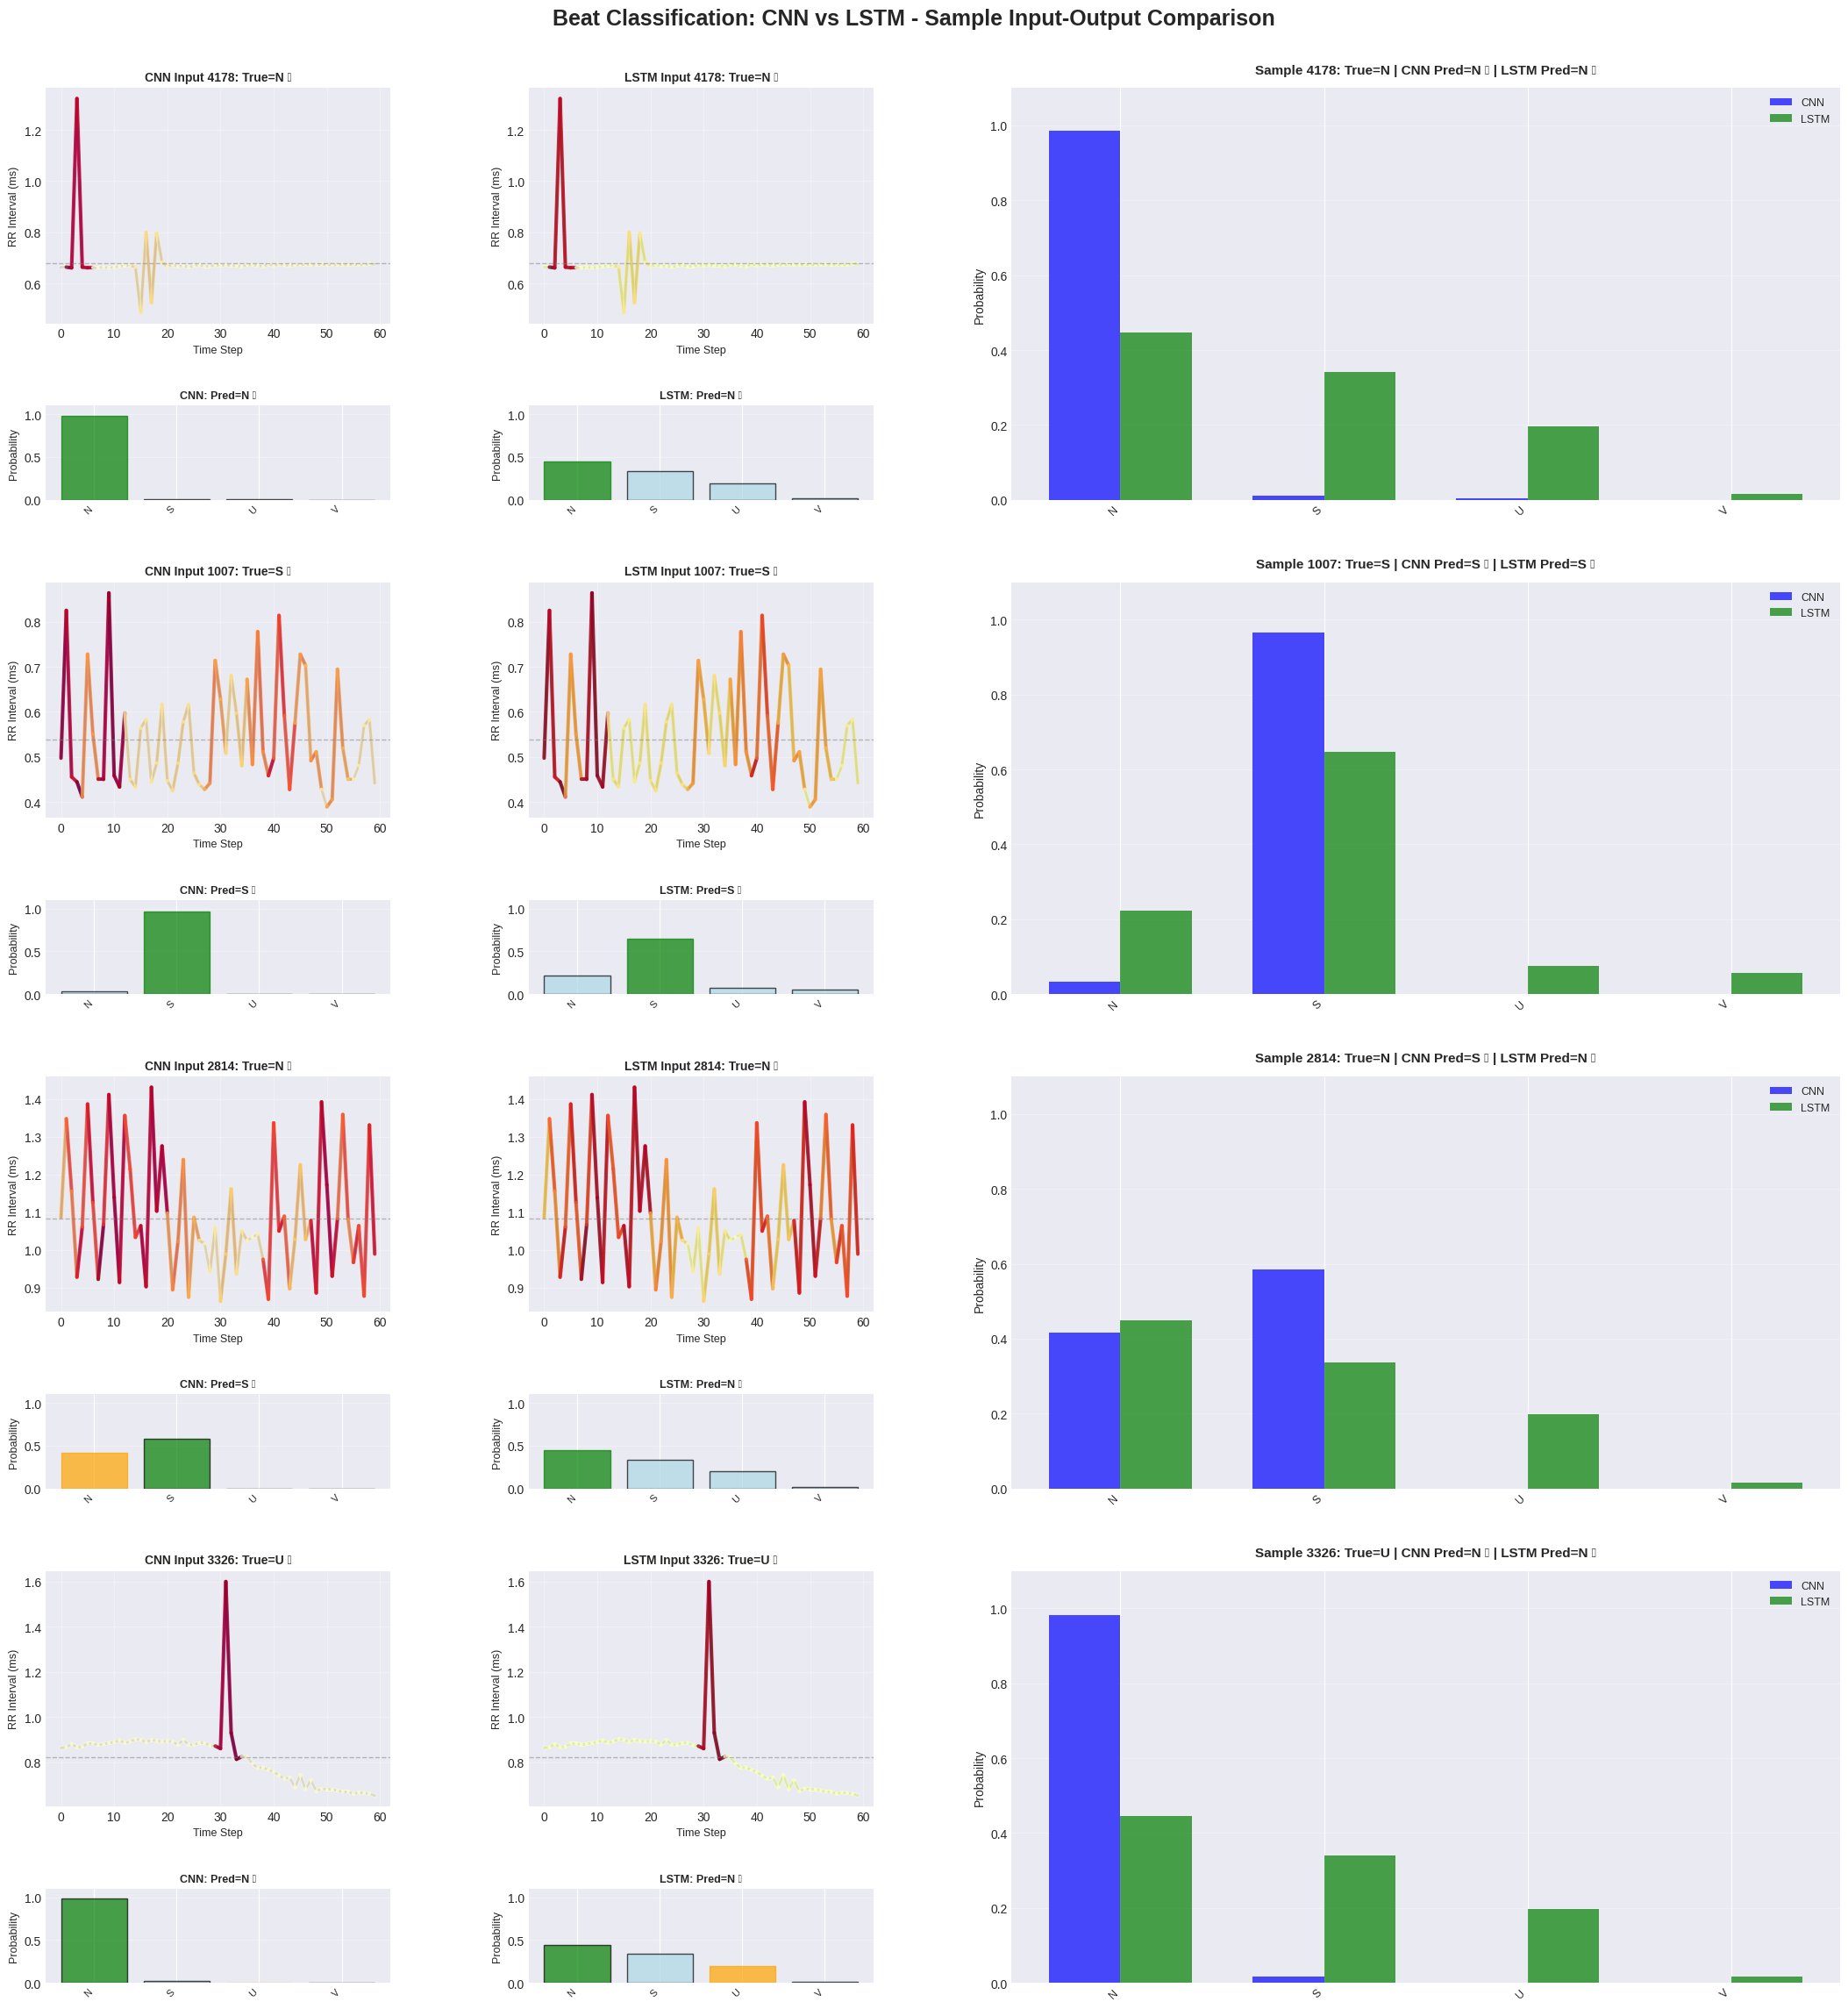


✅ Displayed 4 sample comparisons
   Left columns: Individual model visualizations
   Right columns: Side-by-side probability comparison


In [60]:
# Visualize sample beat classification predictions for both models
if beat_cnn_predictions and beat_lstm_predictions:
    # Get test sequences if available
    cnn_sequences = beat_cnn_predictions.get('test_sequences', None)
    lstm_sequences = beat_lstm_predictions.get('test_sequences', None)
    
    # Select same samples for fair comparison
    np.random.seed(42)
    n_samples = 4
    all_test_true = beat_cnn_predictions['test_true_str']
    
    # Get indices for correct and incorrect predictions (from CNN)
    correct_indices = []
    incorrect_indices = []
    for i, (true, pred) in enumerate(zip(all_test_true, beat_cnn_predictions['test_pred_str'])):
        if true == pred:
            correct_indices.append(i)
        else:
            incorrect_indices.append(i)
    
    selected_indices = []
    if len(correct_indices) > 0:
        selected_indices.extend(np.random.choice(correct_indices, min(2, len(correct_indices)), replace=False).tolist())
    if len(incorrect_indices) > 0:
        selected_indices.extend(np.random.choice(incorrect_indices, min(2, len(incorrect_indices)), replace=False).tolist())
    selected_indices = selected_indices[:n_samples]
    
    # Create visualization with better spacing
    fig = plt.figure(figsize=(22, 6 * n_samples))
    gs = fig.add_gridspec(n_samples * 2, 4, hspace=0.5, wspace=0.4, 
                          height_ratios=[2.5, 1]*n_samples,
                          left=0.05, right=0.98, top=0.96, bottom=0.06)
    
    label_encoder = beat_cnn_predictions['label_encoder']
    
    for idx, sample_idx in enumerate(selected_indices):
        row = idx * 2
        
        # CNN predictions
        cnn_true = beat_cnn_predictions['test_true_str'][sample_idx]
        cnn_pred = beat_cnn_predictions['test_pred_str'][sample_idx]
        cnn_proba = beat_cnn_predictions['test_proba'][sample_idx]
        cnn_correct = (cnn_true == cnn_pred)
        
        # LSTM predictions
        lstm_true = beat_lstm_predictions['test_true_str'][sample_idx]
        lstm_pred = beat_lstm_predictions['test_pred_str'][sample_idx]
        lstm_proba = beat_lstm_predictions['test_proba'][sample_idx]
        lstm_correct = (lstm_true == lstm_pred)
        
        # Use CNN sequences if available, otherwise LSTM
        sequences = cnn_sequences if cnn_sequences is not None else lstm_sequences
        
        # Top row: Input signals
        # CNN signal
        ax_cnn_sig = fig.add_subplot(gs[row, 0])
        if sequences is not None and sample_idx < len(sequences):
            seq = sequences[sample_idx]
            time_steps = np.arange(len(seq))
            ax_cnn_sig.plot(time_steps, seq, 'b-', linewidth=2, alpha=0.7)
            
            # Calculate importance
            window_size = 5
            variance = np.array([np.var(seq[max(0, i-window_size//2):min(len(seq), i+window_size//2+1)]) 
                               for i in range(len(seq))])
            importance = variance / np.max(variance) if np.max(variance) > 0 else variance
            colors = plt.cm.YlOrRd(importance)
            
            for i in range(len(seq) - 1):
                ax_cnn_sig.plot([time_steps[i], time_steps[i+1]], [seq[i], seq[i+1]], 
                              color=colors[i], linewidth=3, alpha=0.8)
            
            mean_rr = np.mean(seq)
            ax_cnn_sig.axhline(y=mean_rr, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        else:
            ax_cnn_sig.text(0.5, 0.5, 'Sequence\nnot available', ha='center', va='center')
            ax_cnn_sig.set_xlim([0, 1])
            ax_cnn_sig.set_ylim([0, 1])
        
        status_cnn = "✅" if cnn_correct else "❌"
        ax_cnn_sig.set_title(f'CNN Input {sample_idx}: True={cnn_true} {status_cnn}', fontsize=10, fontweight='bold')
        ax_cnn_sig.set_xlabel('Time Step', fontsize=9)
        ax_cnn_sig.set_ylabel('RR Interval (ms)', fontsize=9)
        ax_cnn_sig.grid(True, alpha=0.3)
        
        # LSTM signal
        ax_lstm_sig = fig.add_subplot(gs[row, 1])
        if sequences is not None and sample_idx < len(sequences):
            seq = sequences[sample_idx]
            time_steps = np.arange(len(seq))
            ax_lstm_sig.plot(time_steps, seq, 'g-', linewidth=2, alpha=0.7)
            
            # Same importance calculation
            window_size = 5
            variance = np.array([np.var(seq[max(0, i-window_size//2):min(len(seq), i+window_size//2+1)]) 
                               for i in range(len(seq))])
            importance = variance / np.max(variance) if np.max(variance) > 0 else variance
            colors = plt.cm.YlOrRd(importance)
            
            for i in range(len(seq) - 1):
                ax_lstm_sig.plot([time_steps[i], time_steps[i+1]], [seq[i], seq[i+1]], 
                               color=colors[i], linewidth=3, alpha=0.8)
            
            mean_rr = np.mean(seq)
            ax_lstm_sig.axhline(y=mean_rr, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        else:
            ax_lstm_sig.text(0.5, 0.5, 'Sequence\nnot available', ha='center', va='center')
            ax_lstm_sig.set_xlim([0, 1])
            ax_lstm_sig.set_ylim([0, 1])
        
        status_lstm = "✅" if lstm_correct else "❌"
        ax_lstm_sig.set_title(f'LSTM Input {sample_idx}: True={lstm_true} {status_lstm}', fontsize=10, fontweight='bold')
        ax_lstm_sig.set_xlabel('Time Step', fontsize=9)
        ax_lstm_sig.set_ylabel('RR Interval (ms)', fontsize=9)
        ax_lstm_sig.grid(True, alpha=0.3)
        
        # CNN output probabilities
        ax_cnn_prob = fig.add_subplot(gs[row+1, 0])
        bars_cnn = ax_cnn_prob.bar(range(len(label_encoder.classes_)), cnn_proba, 
                                   color=['green' if c == cnn_pred else 'lightblue' for c in label_encoder.classes_],
                                   alpha=0.7, edgecolor='black')
        true_idx = np.where(label_encoder.classes_ == cnn_true)[0][0]
        bars_cnn[true_idx].set_color('orange' if not cnn_correct else 'green')
        ax_cnn_prob.set_xticks(range(len(label_encoder.classes_)))
        ax_cnn_prob.set_xticklabels(label_encoder.classes_, rotation=45, ha='right', fontsize=8)
        ax_cnn_prob.set_ylabel('Probability', fontsize=9)
        ax_cnn_prob.set_ylim([0, 1.1])
        ax_cnn_prob.set_title(f'CNN: Pred={cnn_pred} {status_cnn}', fontsize=9, fontweight='bold')
        ax_cnn_prob.grid(axis='y', alpha=0.3)
        
        # LSTM output probabilities
        ax_lstm_prob = fig.add_subplot(gs[row+1, 1])
        bars_lstm = ax_lstm_prob.bar(range(len(label_encoder.classes_)), lstm_proba,
                                    color=['green' if c == lstm_pred else 'lightblue' for c in label_encoder.classes_],
                                    alpha=0.7, edgecolor='black')
        true_idx = np.where(label_encoder.classes_ == lstm_true)[0][0]
        bars_lstm[true_idx].set_color('orange' if not lstm_correct else 'green')
        ax_lstm_prob.set_xticks(range(len(label_encoder.classes_)))
        ax_lstm_prob.set_xticklabels(label_encoder.classes_, rotation=45, ha='right', fontsize=8)
        ax_lstm_prob.set_ylabel('Probability', fontsize=9)
        ax_lstm_prob.set_ylim([0, 1.1])
        ax_lstm_prob.set_title(f'LSTM: Pred={lstm_pred} {status_lstm}', fontsize=9, fontweight='bold')
        ax_lstm_prob.grid(axis='y', alpha=0.3)
        
        # Comparison side by side
        ax_comp = fig.add_subplot(gs[row:row+2, 2:4])
        x_pos = np.arange(len(label_encoder.classes_))
        width = 0.35
        ax_comp.bar(x_pos - width/2, cnn_proba, width, label='CNN', alpha=0.7, color='blue')
        ax_comp.bar(x_pos + width/2, lstm_proba, width, label='LSTM', alpha=0.7, color='green')
        ax_comp.set_xticks(x_pos)
        ax_comp.set_xticklabels(label_encoder.classes_, rotation=45, ha='right', fontsize=9)
        ax_comp.set_ylabel('Probability', fontsize=10)
        ax_comp.set_title(f'Sample {sample_idx}: True={cnn_true} | CNN Pred={cnn_pred} {status_cnn} | LSTM Pred={lstm_pred} {status_lstm}', 
                         fontsize=11, fontweight='bold', pad=12)
        ax_comp.legend(loc='upper right', fontsize=9, framealpha=0.9)
        ax_comp.grid(axis='y', alpha=0.3)
        ax_comp.set_ylim([0, 1.1])
    
    plt.suptitle('Beat Classification: CNN vs LSTM - Sample Input-Output Comparison', 
                 fontsize=18, fontweight='bold', y=0.998)
    
    # Better spacing to prevent overlap
    plt.subplots_adjust(top=0.94, hspace=0.5, wspace=0.4)
    save_and_show(fig, 'beat_dl_sample_comparison.png')
    
    print(f"\n✅ Displayed {len(selected_indices)} sample comparisons")
    print("   Left columns: Individual model visualizations")
    print("   Right columns: Side-by-side probability comparison")
else:
    print("⚠️  Need both CNN and LSTM predictions for comparison visualization")


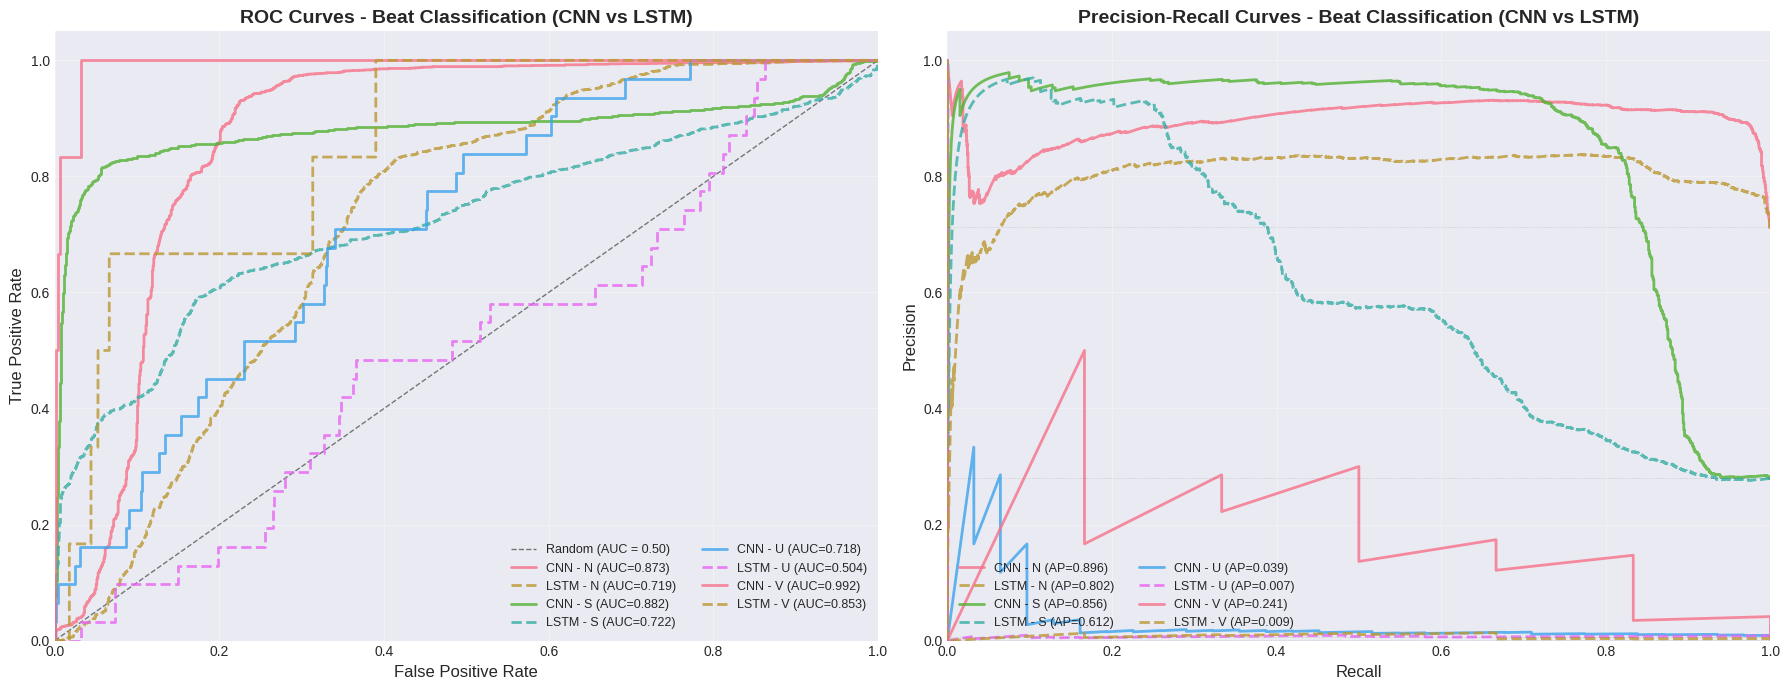

✅ ROC and PR curves displayed
   Solid lines: CNN
   Dashed lines: LSTM


In [61]:
# Multi-model ROC and PR curves for beat classification
if beat_cnn_predictions and beat_lstm_predictions:
    label_encoder = beat_cnn_predictions['label_encoder']
    
    # Prepare binary labels for both models
    y_true_cnn = label_binarize(beat_cnn_predictions['test_true_str'], classes=label_encoder.classes_)
    y_true_lstm = label_binarize(beat_lstm_predictions['test_true_str'], classes=label_encoder.classes_)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # ROC Curves
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)', linewidth=1, alpha=0.5)
    
    for i, class_name in enumerate(label_encoder.classes_):
        # CNN ROC
        fpr_cnn, tpr_cnn, _ = roc_curve(y_true_cnn[:, i], beat_cnn_predictions['test_proba'][:, i])
        auroc_cnn = roc_auc_score(y_true_cnn[:, i], beat_cnn_predictions['test_proba'][:, i])
        if not np.isnan(auroc_cnn):
            axes[0].plot(fpr_cnn, tpr_cnn, linestyle='-', linewidth=2, 
                        label=f'CNN - {class_name} (AUC={auroc_cnn:.3f})', alpha=0.8)
        
        # LSTM ROC
        fpr_lstm, tpr_lstm, _ = roc_curve(y_true_lstm[:, i], beat_lstm_predictions['test_proba'][:, i])
        auroc_lstm = roc_auc_score(y_true_lstm[:, i], beat_lstm_predictions['test_proba'][:, i])
        if not np.isnan(auroc_lstm):
            axes[0].plot(fpr_lstm, tpr_lstm, linestyle='--', linewidth=2, 
                        label=f'LSTM - {class_name} (AUC={auroc_lstm:.3f})', alpha=0.8)
    
    axes[0].set_xlabel('False Positive Rate', fontsize=12)
    axes[0].set_ylabel('True Positive Rate', fontsize=12)
    axes[0].set_title('ROC Curves - Beat Classification (CNN vs LSTM)', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right', fontsize=9, ncol=2)
    axes[0].grid(alpha=0.3)
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    
    # Precision-Recall Curves
    for i, class_name in enumerate(label_encoder.classes_):
        # CNN PR
        precision_cnn, recall_cnn, _ = precision_recall_curve(y_true_cnn[:, i], beat_cnn_predictions['test_proba'][:, i])
        auprc_cnn = average_precision_score(y_true_cnn[:, i], beat_cnn_predictions['test_proba'][:, i])
        if not np.isnan(auprc_cnn):
            axes[1].plot(recall_cnn, precision_cnn, linestyle='-', linewidth=2,
                        label=f'CNN - {class_name} (AP={auprc_cnn:.3f})', alpha=0.8)
        
        # LSTM PR
        precision_lstm, recall_lstm, _ = precision_recall_curve(y_true_lstm[:, i], beat_lstm_predictions['test_proba'][:, i])
        auprc_lstm = average_precision_score(y_true_lstm[:, i], beat_lstm_predictions['test_proba'][:, i])
        if not np.isnan(auprc_lstm):
            axes[1].plot(recall_lstm, precision_lstm, linestyle='--', linewidth=2,
                        label=f'LSTM - {class_name} (AP={auprc_lstm:.3f})', alpha=0.8)
    
    # Baseline
    baseline = np.sum(y_true_cnn, axis=0) / len(y_true_cnn)
    for i, class_name in enumerate(label_encoder.classes_):
        axes[1].axhline(y=baseline[i], color='k', linestyle=':', alpha=0.2, linewidth=0.5)
    
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_ylabel('Precision', fontsize=12)
    axes[1].set_title('Precision-Recall Curves - Beat Classification (CNN vs LSTM)', fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower left', fontsize=9, ncol=2)
    axes[1].grid(alpha=0.3)
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    
    plt.tight_layout()
    plt.show()
    
    print("✅ ROC and PR curves displayed")
    print("   Solid lines: CNN")
    print("   Dashed lines: LSTM")
else:
    print("⚠️  Need both CNN and LSTM predictions for ROC/PR curves")


## Section 6: Rhythm Classification - Sample Input-Output Visualization

Visualize sample inputs and outputs for both CNN and LSTM models for rhythm classification.


💾 Saved figure to: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/plots/rhythm_dl_sample_comparison.png


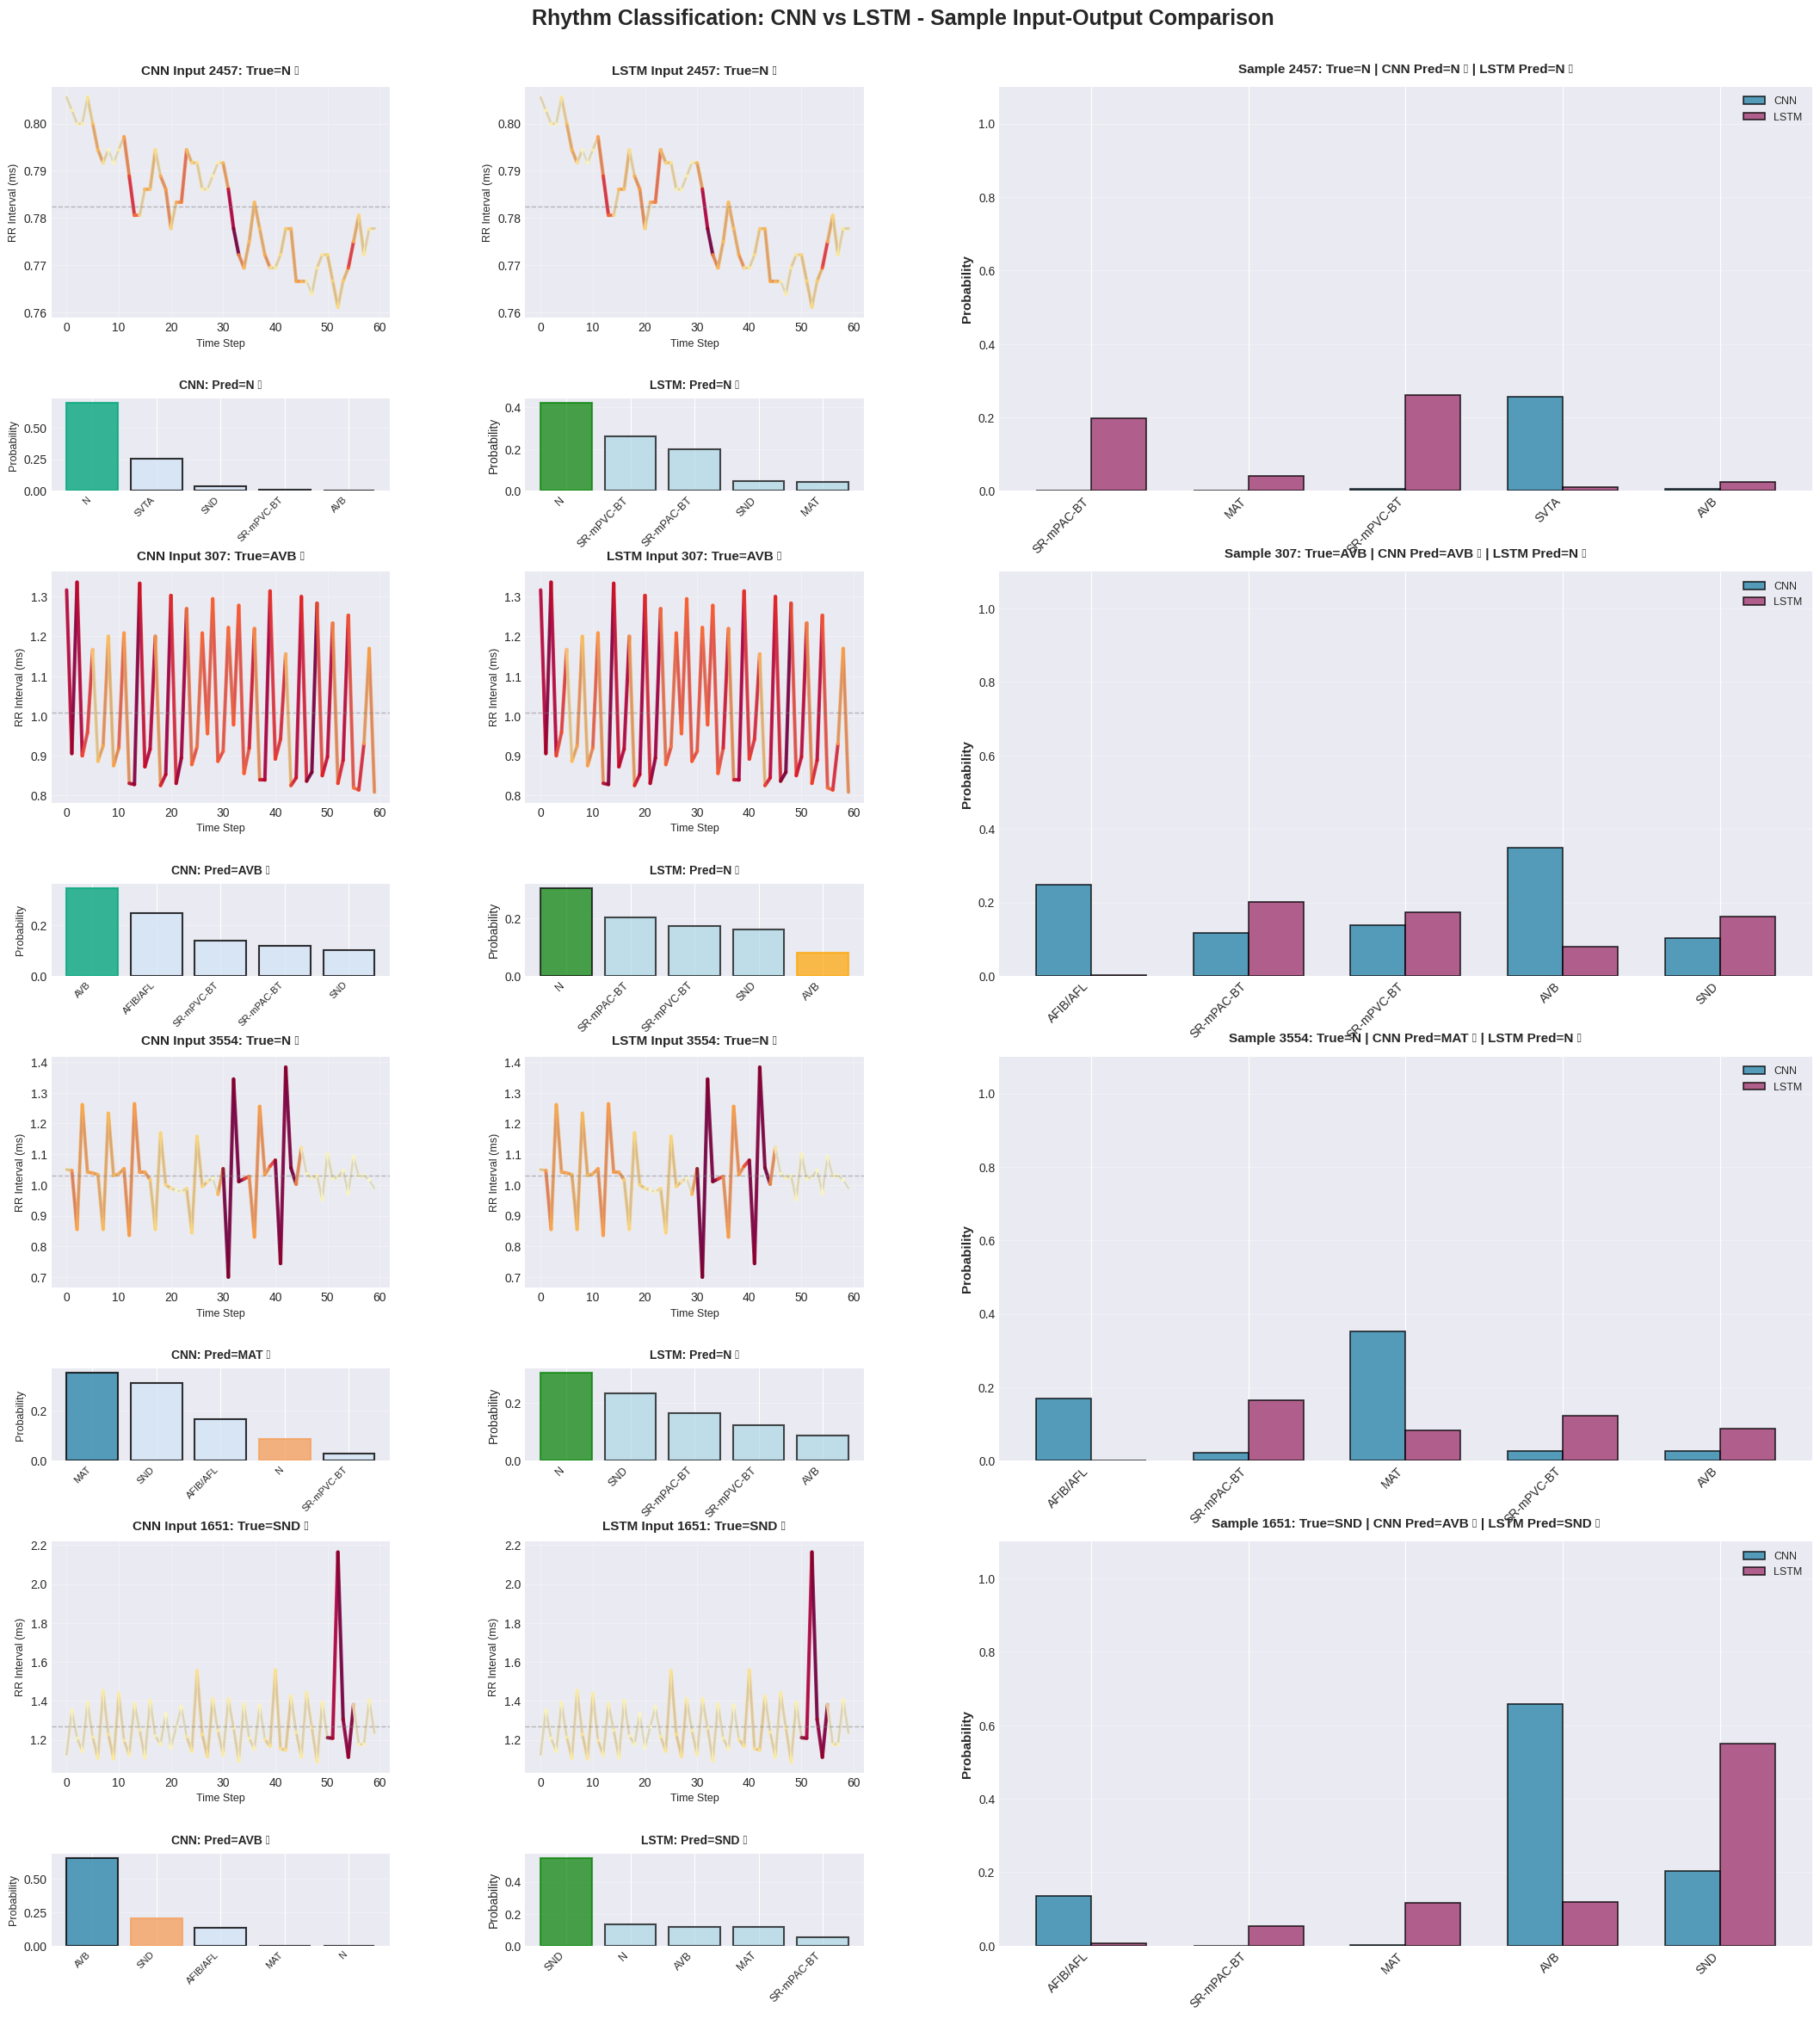


✅ Displayed 4 sample comparisons


In [62]:
# Visualize sample rhythm classification predictions for both models
if rhythm_cnn_predictions and rhythm_lstm_predictions:
    # Get test sequences if available
    cnn_sequences = rhythm_cnn_predictions.get('test_sequences', None)
    lstm_sequences = rhythm_lstm_predictions.get('test_sequences', None)
    
    # Select same samples for fair comparison (use fewer samples due to more classes)
    np.random.seed(42)
    n_samples = 4
    all_test_true = rhythm_cnn_predictions['test_true_str']
    
    # Get indices for correct and incorrect predictions
    correct_indices = []
    incorrect_indices = []
    for i, (true, pred) in enumerate(zip(all_test_true, rhythm_cnn_predictions['test_pred_str'])):
        if true == pred:
            correct_indices.append(i)
        else:
            incorrect_indices.append(i)
    
    selected_indices = []
    if len(correct_indices) > 0:
        selected_indices.extend(np.random.choice(correct_indices, min(2, len(correct_indices)), replace=False).tolist())
    if len(incorrect_indices) > 0:
        selected_indices.extend(np.random.choice(incorrect_indices, min(2, len(incorrect_indices)), replace=False).tolist())
    selected_indices = selected_indices[:n_samples]
    
    # Create visualization with better spacing and enhanced layout
    fig = plt.figure(figsize=(22, 6 * n_samples))
    gs = fig.add_gridspec(n_samples * 2, 4, hspace=0.5, wspace=0.4, 
                          height_ratios=[2.5, 1]*n_samples,
                          left=0.05, right=0.98, top=0.96, bottom=0.06)
    
    label_encoder = rhythm_cnn_predictions['label_encoder']
    
    for idx, sample_idx in enumerate(selected_indices):
        row = idx * 2
        
        # CNN predictions
        cnn_true = rhythm_cnn_predictions['test_true_str'][sample_idx]
        cnn_pred = rhythm_cnn_predictions['test_pred_str'][sample_idx]
        cnn_proba = rhythm_cnn_predictions['test_proba'][sample_idx]
        cnn_correct = (cnn_true == cnn_pred)
        
        # LSTM predictions
        lstm_true = rhythm_lstm_predictions['test_true_str'][sample_idx]
        lstm_pred = rhythm_lstm_predictions['test_pred_str'][sample_idx]
        lstm_proba = rhythm_lstm_predictions['test_proba'][sample_idx]
        lstm_correct = (lstm_true == lstm_pred)
        
        # Use CNN sequences if available, otherwise LSTM
        sequences = cnn_sequences if cnn_sequences is not None else lstm_sequences
        
        # Top row: Input signals (same as beat classification)
        ax_cnn_sig = fig.add_subplot(gs[row, 0])
        ax_lstm_sig = fig.add_subplot(gs[row, 1])
        
        if sequences is not None and sample_idx < len(sequences):
            seq = sequences[sample_idx]
            time_steps = np.arange(len(seq))
            
            for ax in [ax_cnn_sig, ax_lstm_sig]:
                ax.plot(time_steps, seq, 'b-', linewidth=2, alpha=0.7)
                window_size = 5
                variance = np.array([np.var(seq[max(0, i-window_size//2):min(len(seq), i+window_size//2+1)]) 
                                   for i in range(len(seq))])
                importance = variance / np.max(variance) if np.max(variance) > 0 else variance
                colors = plt.cm.YlOrRd(importance)
                for i in range(len(seq) - 1):
                    ax.plot([time_steps[i], time_steps[i+1]], [seq[i], seq[i+1]], 
                          color=colors[i], linewidth=3, alpha=0.8)
                mean_rr = np.mean(seq)
                ax.axhline(y=mean_rr, color='gray', linestyle='--', linewidth=1, alpha=0.5)
                ax.set_xlabel('Time Step', fontsize=9)
                ax.set_ylabel('RR Interval (ms)', fontsize=9)
                ax.grid(True, alpha=0.3)
        else:
            for ax in [ax_cnn_sig, ax_lstm_sig]:
                ax.text(0.5, 0.5, 'Sequence\nnot available', ha='center', va='center')
                ax.set_xlim([0, 1])
                ax.set_ylim([0, 1])
        
        status_cnn = "✅" if cnn_correct else "❌"
        status_lstm = "✅" if lstm_correct else "❌"
        ax_cnn_sig.set_title(f'CNN Input {sample_idx}: True={cnn_true} {status_cnn}', 
                           fontsize=11, fontweight='bold', pad=10)
        ax_lstm_sig.set_title(f'LSTM Input {sample_idx}: True={lstm_true} {status_lstm}', 
                            fontsize=11, fontweight='bold', pad=10)
        
        # Output probabilities (top 5 classes only for clarity)
        top_5_idx = np.argsort(cnn_proba)[-5:][::-1]
        top_5_classes = [label_encoder.classes_[i] for i in top_5_idx]
        
        ax_cnn_prob = fig.add_subplot(gs[row+1, 0])
        bars_cnn = ax_cnn_prob.bar(range(len(top_5_classes)), cnn_proba[top_5_idx],
                                   color=['#2E86AB' if top_5_classes[i] == cnn_pred else '#D4E4F7' 
                                         for i in range(len(top_5_classes))],
                                   alpha=0.8, edgecolor='black', linewidth=1.5)
        if cnn_true in top_5_classes:
            true_top_idx = top_5_classes.index(cnn_true)
            bars_cnn[true_top_idx].set_color('#F4A261' if not cnn_correct else '#06A77D')
        ax_cnn_prob.set_xticks(range(len(top_5_classes)))
        ax_cnn_prob.set_xticklabels(top_5_classes, rotation=45, ha='right', fontsize=8)
        ax_cnn_prob.set_ylabel('Probability', fontsize=9)
        ax_cnn_prob.set_title(f'CNN: Pred={cnn_pred} {status_cnn}', fontsize=10, fontweight='bold', pad=8)
        ax_cnn_prob.grid(axis='y', alpha=0.3)
        
        ax_lstm_prob = fig.add_subplot(gs[row+1, 1])
        top_5_idx_lstm = np.argsort(lstm_proba)[-5:][::-1]
        top_5_classes_lstm = [label_encoder.classes_[i] for i in top_5_idx_lstm]
        bars_lstm = ax_lstm_prob.bar(range(len(top_5_classes_lstm)), lstm_proba[top_5_idx_lstm],
                                    color=['green' if top_5_classes_lstm[i] == lstm_pred else 'lightblue' 
                                          for i in range(len(top_5_classes_lstm))],
                                    alpha=0.7, edgecolor='black', linewidth=1.5)
        if lstm_true in top_5_classes_lstm:
            true_top_idx = top_5_classes_lstm.index(lstm_true)
            bars_lstm[true_top_idx].set_color('orange' if not lstm_correct else 'green')
        ax_lstm_prob.set_xticks(range(len(top_5_classes_lstm)))
        ax_lstm_prob.set_xticklabels(top_5_classes_lstm, rotation=45, ha='right', fontsize=9)
        ax_lstm_prob.set_ylabel('Probability', fontsize=10)
        ax_lstm_prob.set_title(f'LSTM: Pred={lstm_pred} {status_lstm}', fontsize=10, fontweight='bold', pad=8)
        ax_lstm_prob.grid(axis='y', alpha=0.3)
        
        # Comparison side by side (top 5 classes)
        common_top = list(set(top_5_classes) | set(top_5_classes_lstm))[:5]
        ax_comp = fig.add_subplot(gs[row:row+2, 2:4])
        x_pos = np.arange(len(common_top))
        width = 0.35
        cnn_vals = [cnn_proba[np.where(label_encoder.classes_ == c)[0][0]] if c in label_encoder.classes_ else 0 
                   for c in common_top]
        lstm_vals = [lstm_proba[np.where(label_encoder.classes_ == c)[0][0]] if c in label_encoder.classes_ else 0 
                    for c in common_top]
        ax_comp.bar(x_pos - width/2, cnn_vals, width, label='CNN', alpha=0.8, color='#2E86AB', edgecolor='black', linewidth=1.2)
        ax_comp.bar(x_pos + width/2, lstm_vals, width, label='LSTM', alpha=0.8, color='#A23B72', edgecolor='black', linewidth=1.2)
        ax_comp.set_xticks(x_pos)
        ax_comp.set_xticklabels(common_top, rotation=45, ha='right', fontsize=10)
        ax_comp.set_ylabel('Probability', fontsize=11, fontweight='bold')
        ax_comp.set_title(f'Sample {sample_idx}: True={cnn_true} | CNN Pred={cnn_pred} {status_cnn} | LSTM Pred={lstm_pred} {status_lstm}', 
                         fontsize=11, fontweight='bold', pad=12)
        ax_comp.legend(loc='upper right', fontsize=9, framealpha=0.9)
        ax_comp.grid(axis='y', alpha=0.3)
        ax_comp.set_ylim([0, 1.1])
    
    plt.suptitle('Rhythm Classification: CNN vs LSTM - Sample Input-Output Comparison', 
                 fontsize=18, fontweight='bold', y=0.998)
    
    # Better spacing to prevent overlap
    plt.subplots_adjust(top=0.94, hspace=0.5, wspace=0.4)
    save_and_show(fig, 'rhythm_dl_sample_comparison.png')
    
    print(f"\n✅ Displayed {len(selected_indices)} sample comparisons")
else:
    print("⚠️  Need both CNN and LSTM predictions for comparison visualization")


## Section 7: Rhythm Classification - Multi-Model ROC and PR Curves

Compare ROC and Precision-Recall curves for CNN and LSTM models for rhythm classification.


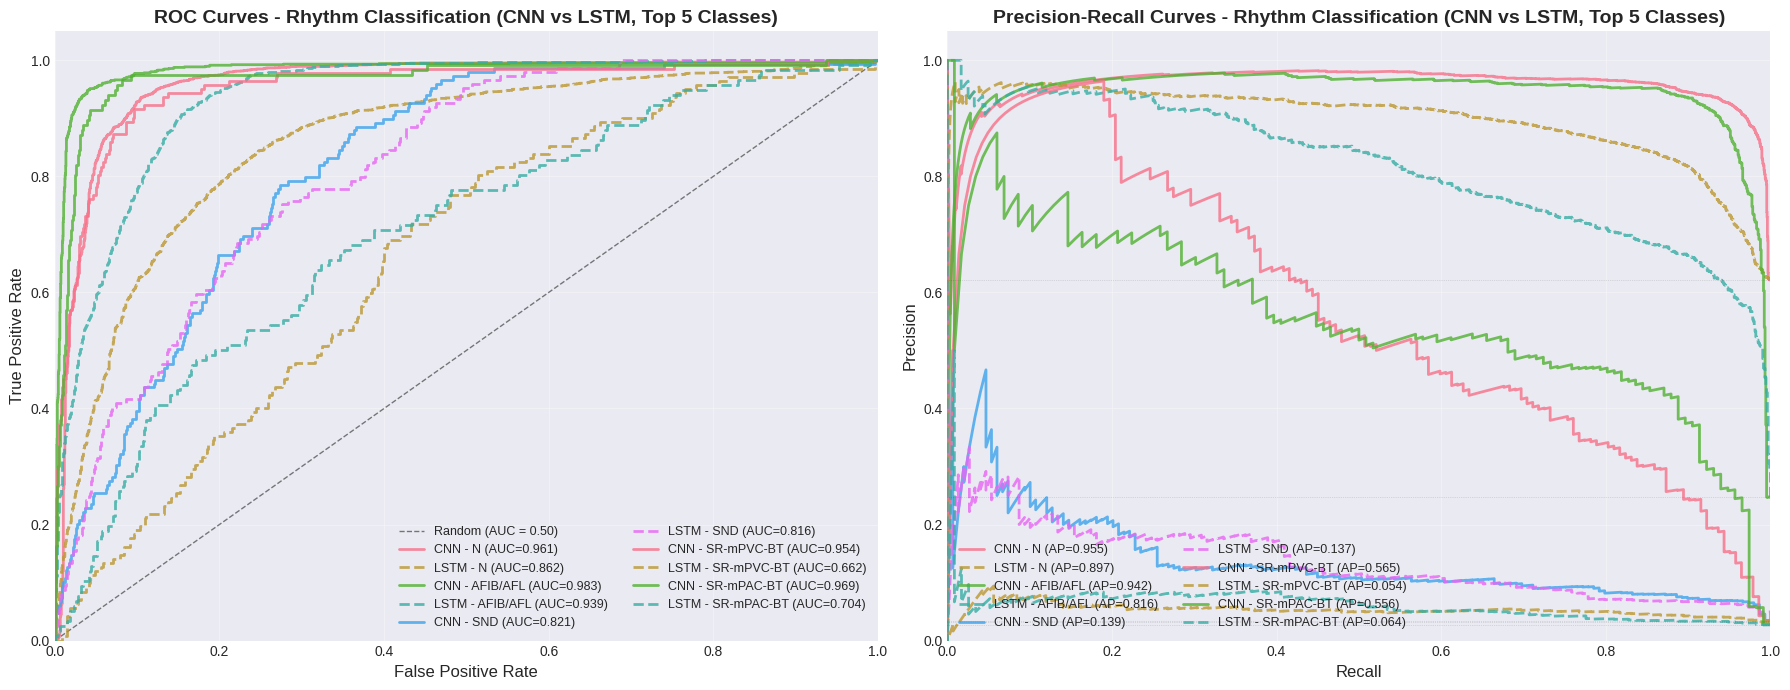

✅ ROC and PR curves displayed (Top 5 classes)
   Solid lines: CNN
   Dashed lines: LSTM


In [63]:
# Multi-model ROC and PR curves for rhythm classification (top 5 classes for clarity)
if rhythm_cnn_predictions and rhythm_lstm_predictions:
    label_encoder = rhythm_cnn_predictions['label_encoder']
    
    # Prepare binary labels
    y_true_cnn = label_binarize(rhythm_cnn_predictions['test_true_str'], classes=label_encoder.classes_)
    y_true_lstm = label_binarize(rhythm_lstm_predictions['test_true_str'], classes=label_encoder.classes_)
    
    # Select top 5 classes by frequency
    class_counts = pd.Series(rhythm_cnn_predictions['test_true_str']).value_counts()
    top_5_classes = class_counts.head(5).index.tolist()
    top_5_indices = [np.where(label_encoder.classes_ == c)[0][0] for c in top_5_classes]
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # ROC Curves (top 5 classes)
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)', linewidth=1, alpha=0.5)
    
    for idx in top_5_indices:
        class_name = label_encoder.classes_[idx]
        # CNN ROC
        fpr_cnn, tpr_cnn, _ = roc_curve(y_true_cnn[:, idx], rhythm_cnn_predictions['test_proba'][:, idx])
        auroc_cnn = roc_auc_score(y_true_cnn[:, idx], rhythm_cnn_predictions['test_proba'][:, idx])
        if not np.isnan(auroc_cnn):
            axes[0].plot(fpr_cnn, tpr_cnn, linestyle='-', linewidth=2, 
                        label=f'CNN - {class_name} (AUC={auroc_cnn:.3f})', alpha=0.8)
        
        # LSTM ROC
        fpr_lstm, tpr_lstm, _ = roc_curve(y_true_lstm[:, idx], rhythm_lstm_predictions['test_proba'][:, idx])
        auroc_lstm = roc_auc_score(y_true_lstm[:, idx], rhythm_lstm_predictions['test_proba'][:, idx])
        if not np.isnan(auroc_lstm):
            axes[0].plot(fpr_lstm, tpr_lstm, linestyle='--', linewidth=2, 
                        label=f'LSTM - {class_name} (AUC={auroc_lstm:.3f})', alpha=0.8)
    
    axes[0].set_xlabel('False Positive Rate', fontsize=12)
    axes[0].set_ylabel('True Positive Rate', fontsize=12)
    axes[0].set_title('ROC Curves - Rhythm Classification (CNN vs LSTM, Top 5 Classes)', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right', fontsize=9, ncol=2)
    axes[0].grid(alpha=0.3)
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    
    # Precision-Recall Curves (top 5 classes)
    for idx in top_5_indices:
        class_name = label_encoder.classes_[idx]
        # CNN PR
        precision_cnn, recall_cnn, _ = precision_recall_curve(y_true_cnn[:, idx], rhythm_cnn_predictions['test_proba'][:, idx])
        auprc_cnn = average_precision_score(y_true_cnn[:, idx], rhythm_cnn_predictions['test_proba'][:, idx])
        if not np.isnan(auprc_cnn):
            axes[1].plot(recall_cnn, precision_cnn, linestyle='-', linewidth=2,
                        label=f'CNN - {class_name} (AP={auprc_cnn:.3f})', alpha=0.8)
        
        # LSTM PR
        precision_lstm, recall_lstm, _ = precision_recall_curve(y_true_lstm[:, idx], rhythm_lstm_predictions['test_proba'][:, idx])
        auprc_lstm = average_precision_score(y_true_lstm[:, idx], rhythm_lstm_predictions['test_proba'][:, idx])
        if not np.isnan(auprc_lstm):
            axes[1].plot(recall_lstm, precision_lstm, linestyle='--', linewidth=2,
                        label=f'LSTM - {class_name} (AP={auprc_lstm:.3f})', alpha=0.8)
    
    # Baseline
    baseline = np.sum(y_true_cnn, axis=0) / len(y_true_cnn)
    for idx in top_5_indices:
        axes[1].axhline(y=baseline[idx], color='k', linestyle=':', alpha=0.2, linewidth=0.5)
    
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_ylabel('Precision', fontsize=12)
    axes[1].set_title('Precision-Recall Curves - Rhythm Classification (CNN vs LSTM, Top 5 Classes)', 
                     fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower left', fontsize=9, ncol=2)
    axes[1].grid(alpha=0.3)
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    
    plt.tight_layout()
    plt.show()
    
    print("✅ ROC and PR curves displayed (Top 5 classes)")
    print("   Solid lines: CNN")
    print("   Dashed lines: LSTM")
else:
    print("⚠️  Need both CNN and LSTM predictions for ROC/PR curves")


## Section 8: Confusion Matrices Comparison

Compare confusion matrices for CNN and LSTM models side by side.


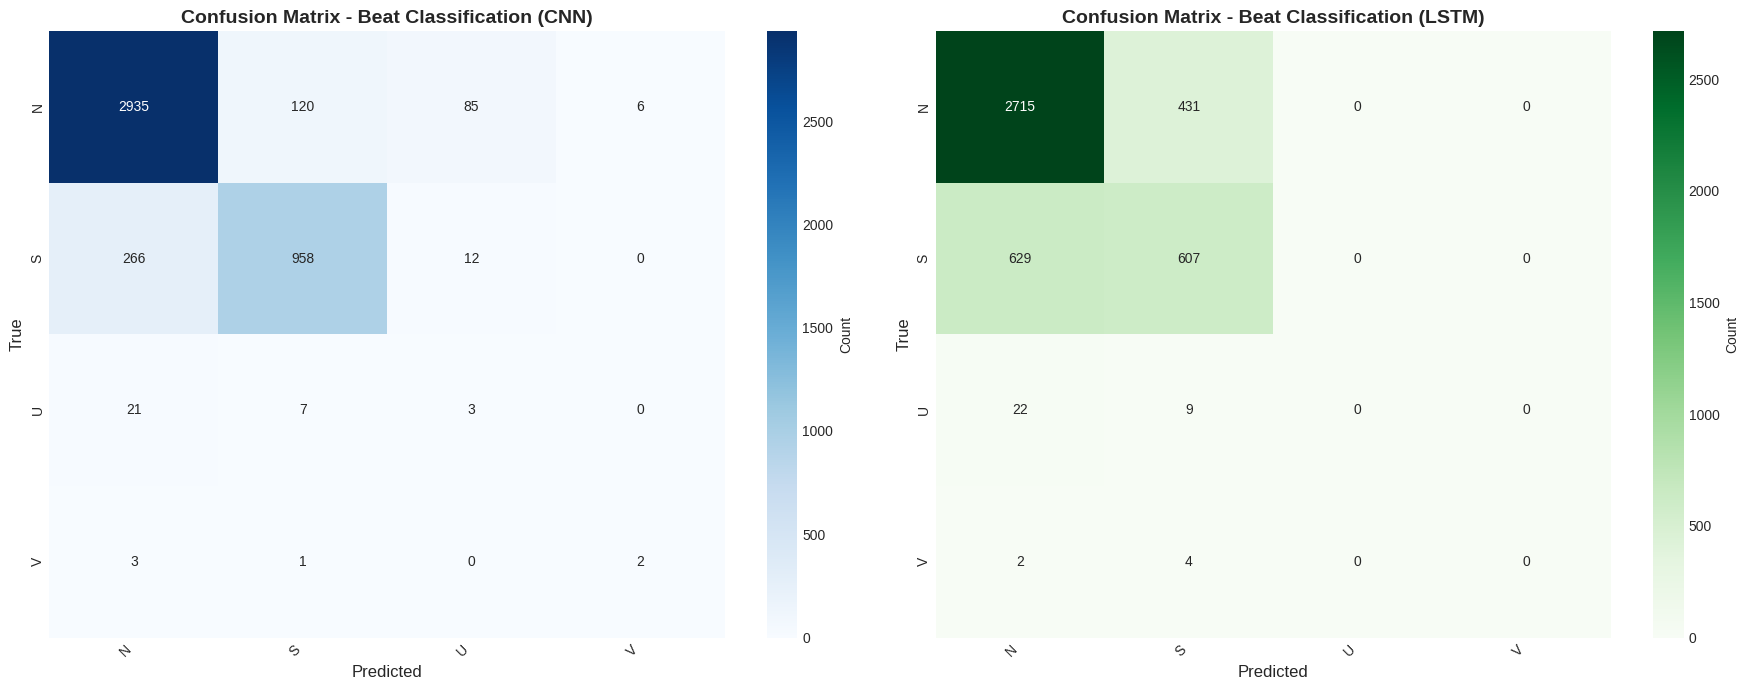

✅ Beat classification confusion matrices displayed
💾 Saved figure to: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/plots/rhythm_confusion_matrices_dl.png


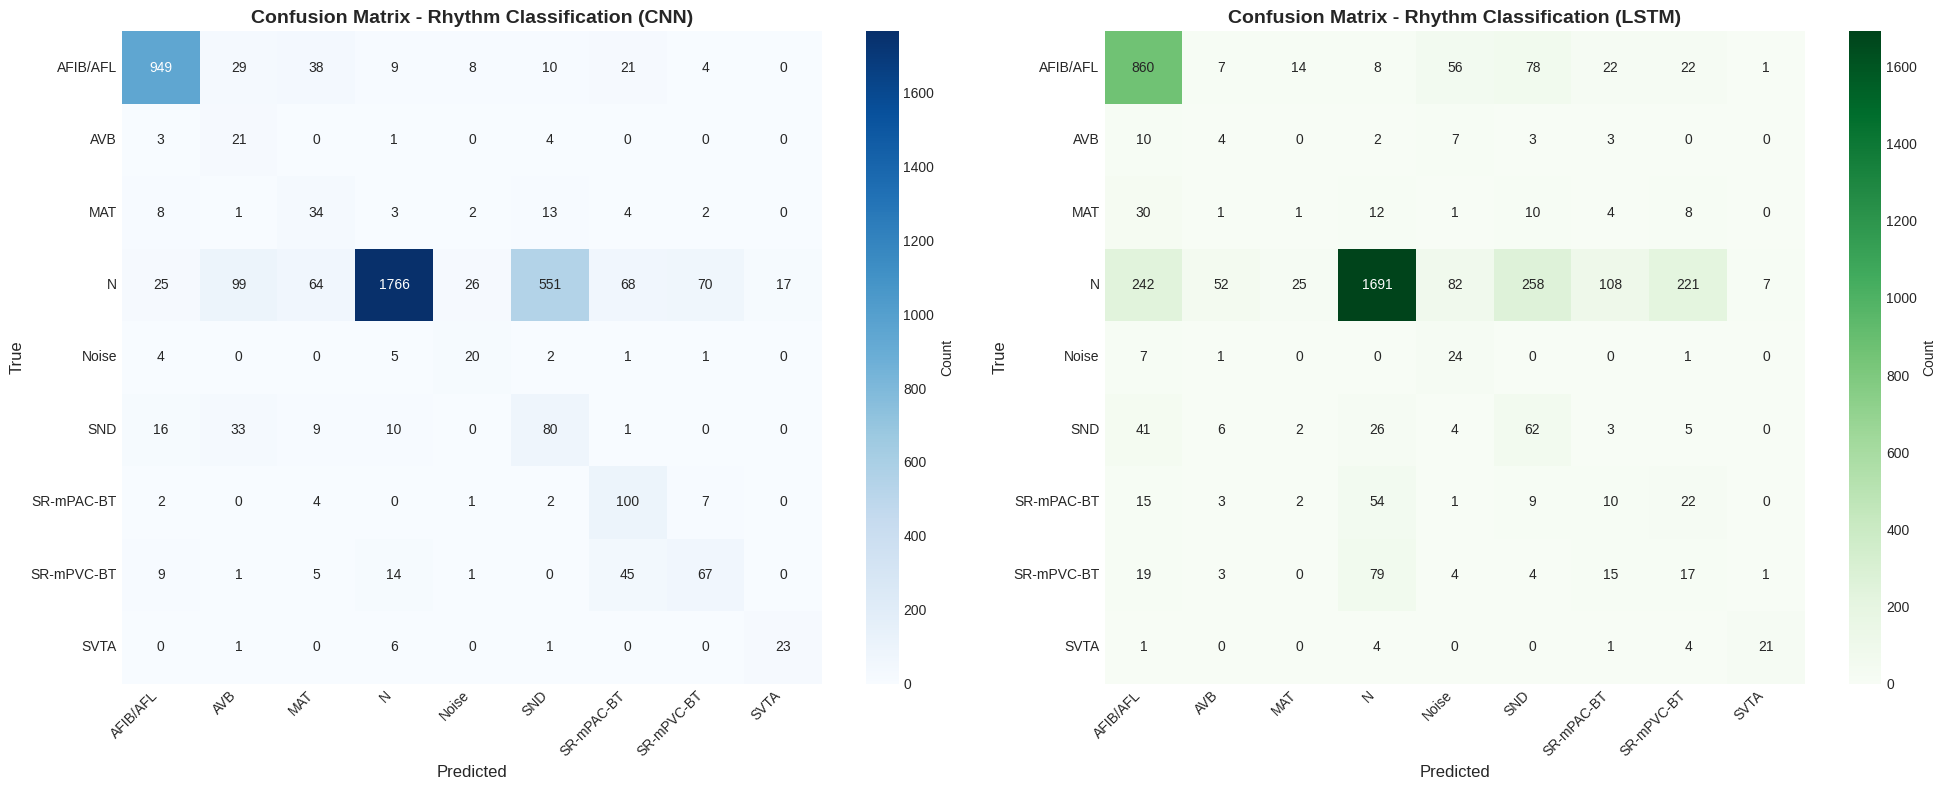

✅ Rhythm classification confusion matrices displayed


In [64]:
# Confusion matrices comparison for beat classification
if beat_cnn_predictions and beat_lstm_predictions:
    label_encoder = beat_cnn_predictions['label_encoder']
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # CNN confusion matrix
    cm_cnn = confusion_matrix(beat_cnn_predictions['test_true_str'], 
                              beat_cnn_predictions['test_pred_str'],
                              labels=label_encoder.classes_)
    sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Count'})
    axes[0].set_title('Confusion Matrix - Beat Classification (CNN)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted', fontsize=12)
    axes[0].set_ylabel('True', fontsize=12)
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
    
    # LSTM confusion matrix
    cm_lstm = confusion_matrix(beat_lstm_predictions['test_true_str'],
                               beat_lstm_predictions['test_pred_str'],
                               labels=label_encoder.classes_)
    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Count'})
    axes[1].set_title('Confusion Matrix - Beat Classification (LSTM)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted', fontsize=12)
    axes[1].set_ylabel('True', fontsize=12)
    plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Beat classification confusion matrices displayed")

# Confusion matrices comparison for rhythm classification
if rhythm_cnn_predictions and rhythm_lstm_predictions:
    label_encoder = rhythm_cnn_predictions['label_encoder']
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # CNN confusion matrix
    cm_cnn = confusion_matrix(rhythm_cnn_predictions['test_true_str'],
                              rhythm_cnn_predictions['test_pred_str'],
                              labels=label_encoder.classes_)
    sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Count'})
    axes[0].set_title('Confusion Matrix - Rhythm Classification (CNN)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted', fontsize=12)
    axes[0].set_ylabel('True', fontsize=12)
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
    
    # LSTM confusion matrix
    cm_lstm = confusion_matrix(rhythm_lstm_predictions['test_true_str'],
                               rhythm_lstm_predictions['test_pred_str'],
                               labels=label_encoder.classes_)
    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Count'})
    axes[1].set_title('Confusion Matrix - Rhythm Classification (LSTM)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted', fontsize=12)
    axes[1].set_ylabel('True', fontsize=12)
    plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    save_and_show(fig, 'rhythm_confusion_matrices_dl.png')
    
    print("✅ Rhythm classification confusion matrices displayed")
else:
    print("⚠️  Need both CNN and LSTM predictions for confusion matrix comparison")


## Section 9: Overall Performance Summary

Create a comprehensive summary table comparing all models (DL + ML) across both tasks.


COMPREHENSIVE MODEL PERFORMANCE SUMMARY

📊 Overall Performance Comparison:

----------------------------------------------------------------------------------------------------

Beat Classification:
----------------------------------------------------------------------------------------------------
             Model Model Type  Accuracy  F1 (Macro)  F1 (Weighted)  AUROC (Macro)  AUPRC (Macro)  Precision (Macro)  Recall (Macro)
               CNN         DL  0.882100    0.519507       0.887447       0.866524       0.508178           0.518053        0.534530
           XGBoost         ML  0.761711    0.442377       0.823332       0.915312       0.479623           0.468987        0.768735
              LSTM         DL  0.751754    0.341104       0.741926       0.699423       0.357579           0.345915        0.338525
LogisticRegression         ML  0.750849    0.414906       0.805809       0.776652       0.457488           0.433628        0.540397
      RandomForest         ML  0.534284 

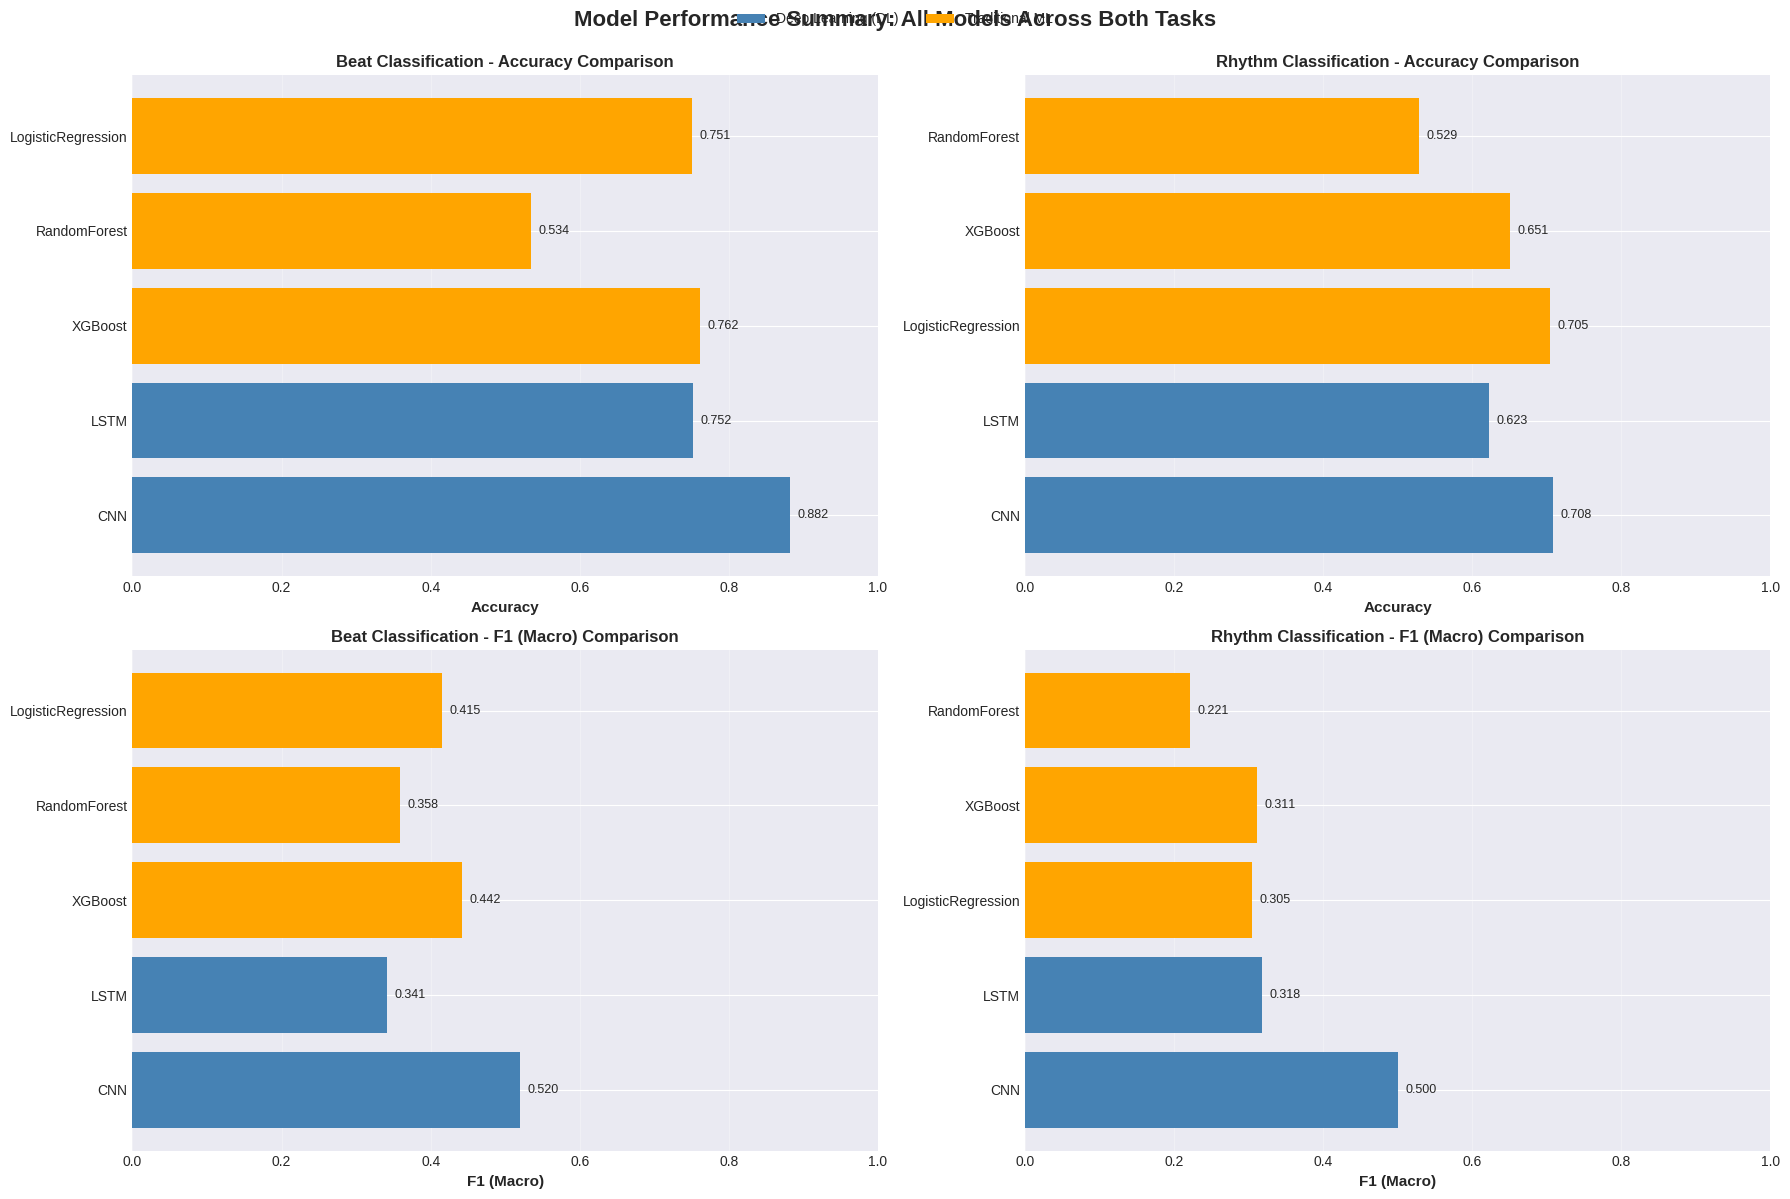

In [65]:
# Create comprehensive summary table of all models across both tasks
print("=" * 100)
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("=" * 100)

# Collect all model metrics
all_models_summary = []

# Beat classification models
if len(beat_metrics) > 0:
    for model_name, metrics in beat_metrics.items():
        all_models_summary.append({
            'Task': 'Beat Classification',
            'Model': model_name,
            'Model Type': 'DL' if model_name in ['CNN', 'LSTM'] else 'ML',
            'Accuracy': metrics['accuracy'],
            'F1 (Macro)': metrics['f1_macro'],
            'F1 (Weighted)': metrics['f1_weighted'],
            'AUROC (Macro)': metrics['auroc'],
            'AUPRC (Macro)': metrics['auprc'],
            'Precision (Macro)': metrics['precision_macro'],
            'Recall (Macro)': metrics['recall_macro'],
        })

# Rhythm classification models
if len(rhythm_metrics) > 0:
    for model_name, metrics in rhythm_metrics.items():
        all_models_summary.append({
            'Task': 'Rhythm Classification',
            'Model': model_name,
            'Model Type': 'DL' if model_name in ['CNN', 'LSTM'] else 'ML',
            'Accuracy': metrics['accuracy'],
            'F1 (Macro)': metrics['f1_macro'],
            'F1 (Weighted)': metrics['f1_weighted'],
            'AUROC (Macro)': metrics['auroc'],
            'AUPRC (Macro)': metrics['auprc'],
            'Precision (Macro)': metrics['precision_macro'],
            'Recall (Macro)': metrics['recall_macro'],
        })

if len(all_models_summary) > 0:
    summary_df = pd.DataFrame(all_models_summary)
    
    # Create formatted summary table
    print("\n📊 Overall Performance Comparison:")
    print("\n" + "-" * 100)
    
    # Display by task
    for task in ['Beat Classification', 'Rhythm Classification']:
        task_df = summary_df[summary_df['Task'] == task].copy()
        if len(task_df) > 0:
            # Sort by accuracy
            task_df = task_df.sort_values('Accuracy', ascending=False)
            
            print(f"\n{task}:")
            print("-" * 100)
            display_cols = ['Model', 'Model Type', 'Accuracy', 'F1 (Macro)', 'F1 (Weighted)', 
                          'AUROC (Macro)', 'AUPRC (Macro)', 'Precision (Macro)', 'Recall (Macro)']
            print(task_df[display_cols].to_string(index=False))
            
            # Highlight best model for key metrics (handle NaN values)
            best_acc = task_df.loc[task_df['Accuracy'].idxmax(), 'Model']
            best_f1_macro = task_df.loc[task_df['F1 (Macro)'].idxmax(), 'Model']
            
            # For AUROC and AUPRC, skip NaN values
            auroc_valid = task_df['AUROC (Macro)'].dropna()
            if len(auroc_valid) > 0:
                best_auroc = task_df.loc[auroc_valid.idxmax(), 'Model']
            else:
                best_auroc = "N/A (all NaN)"
            
            auprc_valid = task_df['AUPRC (Macro)'].dropna()
            if len(auprc_valid) > 0:
                best_auprc = task_df.loc[auprc_valid.idxmax(), 'Model']
            else:
                best_auprc = "N/A (all NaN)"
            
            print(f"\n   🏆 Best Models:")
            print(f"      Accuracy: {best_acc} ({task_df.loc[task_df['Accuracy'].idxmax(), 'Accuracy']:.4f})")
            print(f"      F1 (Macro): {best_f1_macro} ({task_df.loc[task_df['F1 (Macro)'].idxmax(), 'F1 (Macro)']:.4f})")
            if best_auroc != "N/A (all NaN)":
                auroc_val = task_df.loc[auroc_valid.idxmax(), 'AUROC (Macro)']
                print(f"      AUROC: {best_auroc} ({auroc_val:.4f})")
            else:
                print(f"      AUROC: {best_auroc}")
            if best_auprc != "N/A (all NaN)":
                auprc_val = task_df.loc[auprc_valid.idxmax(), 'AUPRC (Macro)']
                print(f"      AUPRC: {best_auprc} ({auprc_val:.4f})")
            else:
                print(f"      AUPRC: {best_auprc}")
    
    # Overall summary
    print("\n" + "=" * 100)
    print("SUMMARY STATISTICS:")
    print("=" * 100)
    
    # Model type comparison
    model_type_stats = summary_df.groupby('Model Type').agg({
        'Accuracy': ['mean', 'std'],
        'F1 (Macro)': ['mean', 'std'],
        'AUROC (Macro)': ['mean', 'std'],
    }).round(4)
    
    print("\n📈 Performance by Model Type (Mean ± Std across both tasks):")
    print(model_type_stats)
    
    # Task comparison
    task_stats = summary_df.groupby('Task').agg({
        'Accuracy': ['mean', 'std', 'min', 'max'],
        'F1 (Macro)': ['mean', 'std', 'min', 'max'],
    }).round(4)
    
    print("\n📊 Performance by Task:")
    print(task_stats)
    
    # Best overall model per task
    print("\n" + "=" * 100)
    print("🏆 BEST OVERALL MODEL PER TASK:")
    print("=" * 100)
    
    for task in ['Beat Classification', 'Rhythm Classification']:
        task_df = summary_df[summary_df['Task'] == task].copy()
        if len(task_df) > 0:
            # Use composite score (weighted average of key metrics)
            # Handle NaN values by replacing with 0 or skipping in average
            auroc_vals = task_df['AUROC (Macro)'].fillna(0)
            auprc_vals = task_df['AUPRC (Macro)'].fillna(0)
            
            task_df['Composite Score'] = (
                0.25 * task_df['Accuracy'] +
                0.25 * task_df['F1 (Macro)'] +
                0.25 * auroc_vals +
                0.25 * auprc_vals
            )
            best_overall = task_df.loc[task_df['Composite Score'].idxmax()]
            
            print(f"\n{task}:")
            print(f"   Model: {best_overall['Model']} ({best_overall['Model Type']})")
            print(f"   Accuracy: {best_overall['Accuracy']:.4f}")
            print(f"   F1 (Macro): {best_overall['F1 (Macro)']:.4f}")
            print(f"   AUROC: {best_overall['AUROC (Macro)']:.4f}")
            print(f"   AUPRC: {best_overall['AUPRC (Macro)']:.4f}")
            print(f"   Composite Score: {best_overall['Composite Score']:.4f}")
    
    print("\n" + "=" * 100)
    print("✅ Summary complete!")
    print("=" * 100)
    
    # Save summary table to CSV
    summary_csv_path = os.path.join(metrics_dir, 'overall_performance_comparison.csv')
    summary_df.to_csv(summary_csv_path, index=False)
    print(f"\n💾 Saved summary table to: {summary_csv_path}")
    
    # Also save as Excel for better formatting
    try:
        summary_excel_path = os.path.join(metrics_dir, 'overall_performance_comparison.xlsx')
        summary_df.to_excel(summary_excel_path, index=False, engine='openpyxl')
        print(f"💾 Saved summary table (Excel) to: {summary_excel_path}")
    except ImportError:
        print("   ℹ️  Excel export requires openpyxl. Install with: pip install openpyxl")
    
    # Create visual summary
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Accuracy comparison by task
    beat_task = summary_df[summary_df['Task'] == 'Beat Classification']
    rhythm_task = summary_df[summary_df['Task'] == 'Rhythm Classification']
    
    if len(beat_task) > 0:
        axes[0, 0].barh(beat_task['Model'], beat_task['Accuracy'], 
                       color=['steelblue' if m == 'DL' else 'orange' 
                             for m in beat_task['Model Type']])
        axes[0, 0].set_xlabel('Accuracy', fontsize=11, fontweight='bold')
        axes[0, 0].set_title('Beat Classification - Accuracy Comparison', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlim([0, 1])
        axes[0, 0].grid(axis='x', alpha=0.3)
        for i, (model, acc) in enumerate(zip(beat_task['Model'], beat_task['Accuracy'])):
            axes[0, 0].text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=9)
    
    if len(rhythm_task) > 0:
        axes[0, 1].barh(rhythm_task['Model'], rhythm_task['Accuracy'],
                        color=['steelblue' if m == 'DL' else 'orange' 
                              for m in rhythm_task['Model Type']])
        axes[0, 1].set_xlabel('Accuracy', fontsize=11, fontweight='bold')
        axes[0, 1].set_title('Rhythm Classification - Accuracy Comparison', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlim([0, 1])
        axes[0, 1].grid(axis='x', alpha=0.3)
        for i, (model, acc) in enumerate(zip(rhythm_task['Model'], rhythm_task['Accuracy'])):
            axes[0, 1].text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=9)
    
    # 2. F1-Macro comparison
    if len(beat_task) > 0:
        axes[1, 0].barh(beat_task['Model'], beat_task['F1 (Macro)'],
                       color=['steelblue' if m == 'DL' else 'orange' 
                             for m in beat_task['Model Type']])
        axes[1, 0].set_xlabel('F1 (Macro)', fontsize=11, fontweight='bold')
        axes[1, 0].set_title('Beat Classification - F1 (Macro) Comparison', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlim([0, 1])
        axes[1, 0].grid(axis='x', alpha=0.3)
        for i, (model, f1) in enumerate(zip(beat_task['Model'], beat_task['F1 (Macro)'])):
            axes[1, 0].text(f1 + 0.01, i, f'{f1:.3f}', va='center', fontsize=9)
    
    if len(rhythm_task) > 0:
        axes[1, 1].barh(rhythm_task['Model'], rhythm_task['F1 (Macro)'],
                        color=['steelblue' if m == 'DL' else 'orange' 
                              for m in rhythm_task['Model Type']])
        axes[1, 1].set_xlabel('F1 (Macro)', fontsize=11, fontweight='bold')
        axes[1, 1].set_title('Rhythm Classification - F1 (Macro) Comparison', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlim([0, 1])
        axes[1, 1].grid(axis='x', alpha=0.3)
        for i, (model, f1) in enumerate(zip(rhythm_task['Model'], rhythm_task['F1 (Macro)'])):
            axes[1, 1].text(f1 + 0.01, i, f'{f1:.3f}', va='center', fontsize=9)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='steelblue', label='Deep Learning (DL)'),
        Patch(facecolor='orange', label='Traditional ML')
    ]
    fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=10, framealpha=0.9)
    
    plt.suptitle('Model Performance Summary: All Models Across Both Tasks', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    save_and_show(fig, 'overall_performance_summary.png')
    
else:
    print("⚠️  No model metrics available. Please ensure predictions are loaded.")


📊 Creating beat classification ML sample visualizations...
Filtered 21 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 49 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 10 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 46 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 50 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 9 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 26 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 5 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 2 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 7 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 6 samples from 'rhythm_lab

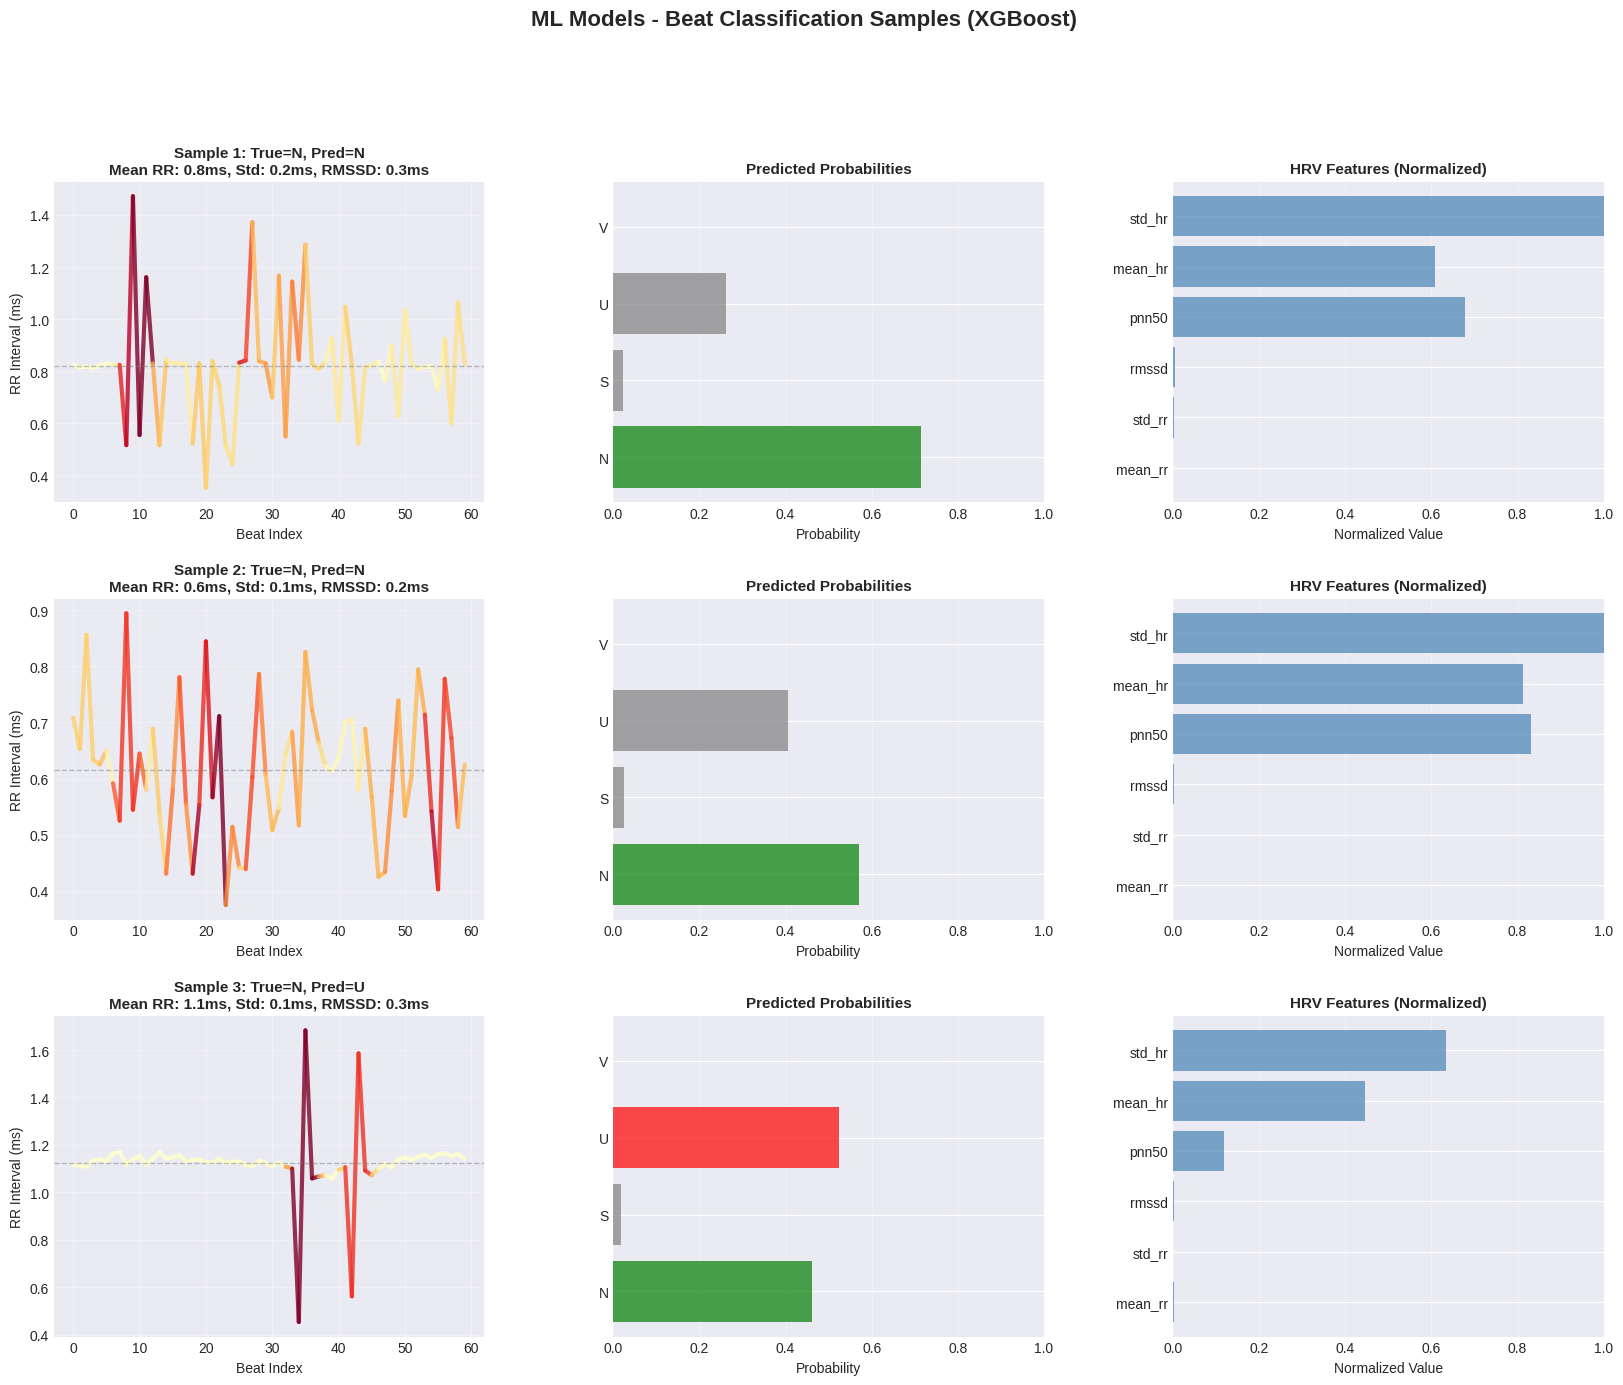

✅ Beat classification ML visualization complete (Model: XGBoost)

📊 Creating rhythm classification ML sample visualizations...
Filtered 21 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 49 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 10 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 46 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 50 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 9 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 26 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 5 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 2 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 7 samples from 'rhythm_label' (excluded classes:

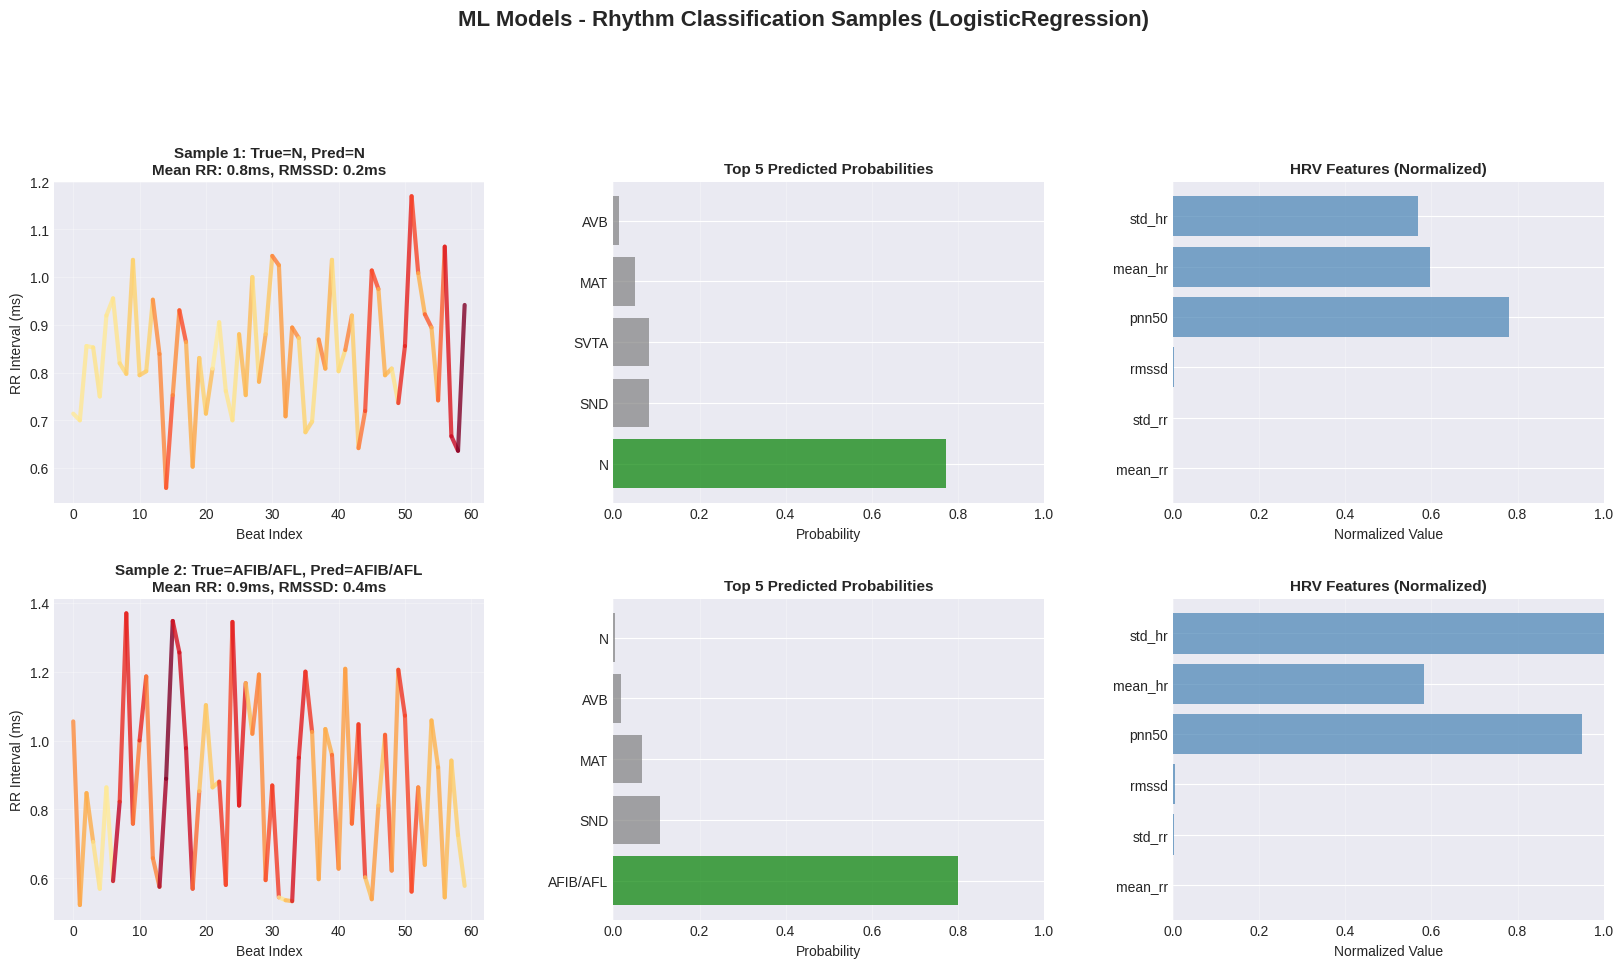

✅ Rhythm classification ML visualization complete (Model: LogisticRegression)

✅ ML Models sample visualizations complete!


In [66]:
# ML Models Sample Input-Output Visualization
# Load test data and recreate HRV features for visualization
if len(beat_ml_predictions) > 0 or len(rhythm_ml_predictions) > 0:
    # Helper function to load test data for visualization
    def load_ml_test_data(task_name):
        """Load test data for ML visualization."""
        # Regenerate test sequences from raw data
        annotations_dict, metadata_df = load_all_cases()
        sequences, labels, patient_ids = create_sequence_dataset(
            annotations_dict, metadata_df, window_size=60, stride=30, task=task_name
        )
        
        # Get patient splits (same as trad_ml.ipynb)
        unique_patients = np.unique(patient_ids)
        np.random.seed(42)
        np.random.shuffle(unique_patients)
        n_train = int(0.6 * len(unique_patients))
        n_val = int(0.2 * len(unique_patients))
        test_patients = set(unique_patients[n_train+n_val:])
        test_mask = np.array([pid in test_patients for pid in patient_ids])
        
        # Convert sequences to list (ensure it's a list, not DataFrame)
        if isinstance(sequences, pd.DataFrame):
            test_sequences = [sequences.iloc[i].values for i in range(len(sequences)) if test_mask[i]]
        else:
            test_sequences = [sequences[i] for i in range(len(sequences)) if test_mask[i]]
        
        # Get test labels
        test_labels = np.array(labels)[test_mask] if labels is not None else None
        
        # Get saved predictions for alignment
        saved_pred_path = find_prediction_file(f'{task_name}_classification_ml_predictions.pkl')
        saved_test_true = None
        if saved_pred_path and os.path.exists(saved_pred_path):
            with open(saved_pred_path, 'rb') as f:
                saved_pred = pickle.load(f)
            saved_test_true = saved_pred.get('test_true_str')
        
        return test_sequences, saved_test_true if saved_test_true is not None else test_labels
    
    # Beat Classification ML Visualization
    if len(beat_ml_predictions) > 0:
        print("📊 Creating beat classification ML sample visualizations...")
        
        # Get test sequences
        beat_test_sequences, beat_test_labels = load_ml_test_data('beat')
        
        if beat_test_sequences is not None and len(beat_ml_predictions) > 0:
            # Select best ML model for visualization
            best_ml_model = None
            best_acc = 0
            for model_name, preds in beat_ml_predictions.items():
                if 'test_true_str' in preds and 'test_pred_str' in preds:
                    acc = accuracy_score(preds['test_true_str'], preds['test_pred_str'])
                    if acc > best_acc:
                        best_acc = acc
                        best_ml_model = (model_name, preds)
            
            if best_ml_model is not None:
                model_name, ml_preds = best_ml_model
                label_encoder = ml_preds['label_encoder']
                test_pred_str = ml_preds['test_pred_str']
                test_true_str = ml_preds['test_true_str']
                test_proba = ml_preds['test_proba']
                
                # Select samples
                np.random.seed(42)
                n_samples = 3
                correct_indices = [i for i, (t, p) in enumerate(zip(test_true_str, test_pred_str)) if t == p]
                incorrect_indices = [i for i, (t, p) in enumerate(zip(test_true_str, test_pred_str)) if t != p]
                
                selected = []
                if len(correct_indices) > 0:
                    selected.extend(np.random.choice(correct_indices, min(2, len(correct_indices)), replace=False).tolist())
                if len(incorrect_indices) > 0:
                    selected.extend(np.random.choice(incorrect_indices, min(1, len(incorrect_indices)), replace=False).tolist())
                selected = selected[:n_samples]
                
                # Create visualization
                fig = plt.figure(figsize=(20, 5 * n_samples))
                gs = fig.add_gridspec(n_samples, 3, hspace=0.3, wspace=0.3)
                
                for idx, sample_idx in enumerate(selected):
                    if sample_idx < len(beat_test_sequences) and sample_idx < len(test_true_str):
                        seq = beat_test_sequences[sample_idx]
                        
                        # Ensure seq is a numpy array
                        if isinstance(seq, (list, pd.Series)):
                            seq = np.array(seq)
                        elif isinstance(seq, pd.DataFrame):
                            seq = seq.values.flatten()
                        if not isinstance(seq, np.ndarray):
                            seq = np.array(seq)
                        
                        # 1. Input signal (RR intervals) with feature importance
                        ax1 = fig.add_subplot(gs[idx, 0])
                        time_steps = np.arange(len(seq))
                        
                        # Calculate importance (local variance)
                        window_size = 5
                        variance = np.array([np.var(seq[max(0, i-window_size//2):min(len(seq), i+window_size//2+1)]) 
                                           for i in range(len(seq))])
                        importance = variance / np.max(variance) if np.max(variance) > 0 else variance
                        colors = plt.cm.YlOrRd(importance)
                        
                        for i in range(len(seq) - 1):
                            ax1.plot([time_steps[i], time_steps[i+1]], [seq[i], seq[i+1]], 
                                    color=colors[i], linewidth=3, alpha=0.8)
                        
                        mean_rr = np.mean(seq)
                        std_rr = np.std(seq)
                        ax1.axhline(y=mean_rr, color='gray', linestyle='--', linewidth=1, alpha=0.5)
                        
                        # Extract HRV features for display
                        hrv_feat = extract_hrv_features(seq)
                        title_text = f"Sample {idx+1}: True={test_true_str[sample_idx]}, Pred={test_pred_str[sample_idx]}"
                        title_text += f"\nMean RR: {mean_rr:.1f}ms, Std: {std_rr:.1f}ms, RMSSD: {hrv_feat.get('rmssd', 0):.1f}ms"
                        ax1.set_title(title_text, fontsize=11, fontweight='bold')
                        ax1.set_xlabel('Beat Index', fontsize=10)
                        ax1.set_ylabel('RR Interval (ms)', fontsize=10)
                        ax1.grid(True, alpha=0.3)
                        
                        # 2. Output probabilities
                        ax2 = fig.add_subplot(gs[idx, 1])
                        proba_dict = {label_encoder.classes_[i]: test_proba[sample_idx][i] 
                                     for i in range(len(label_encoder.classes_))}
                        colors_proba = ['green' if c == test_true_str[sample_idx] else 
                                      'red' if c == test_pred_str[sample_idx] else 'gray' 
                                      for c in label_encoder.classes_]
                        ax2.barh(label_encoder.classes_, list(proba_dict.values()), color=colors_proba, alpha=0.7)
                        ax2.set_xlabel('Probability', fontsize=10)
                        ax2.set_title(f'Predicted Probabilities', fontsize=11, fontweight='bold')
                        ax2.set_xlim([0, 1])
                        ax2.grid(axis='x', alpha=0.3)
                        
                        # 3. HRV Features
                        ax3 = fig.add_subplot(gs[idx, 2])
                        feature_names = ['mean_rr', 'std_rr', 'rmssd', 'pnn50', 'mean_hr', 'std_hr']
                        feature_values = [hrv_feat.get(f, 0) for f in feature_names]
                        # Normalize for display
                        max_vals = [1000, 200, 100, 100, 120, 20]  # Approximate max values
                        feature_values_norm = [v/max_v if max_v > 0 else 0 
                                             for v, max_v in zip(feature_values, max_vals)]
                        ax3.barh(feature_names, feature_values_norm, color='steelblue', alpha=0.7)
                        ax3.set_xlabel('Normalized Value', fontsize=10)
                        ax3.set_title('HRV Features (Normalized)', fontsize=11, fontweight='bold')
                        ax3.set_xlim([0, 1])
                        ax3.grid(axis='x', alpha=0.3)
                
                plt.suptitle(f'ML Models - Beat Classification Samples ({model_name})', 
                           fontsize=16, fontweight='bold', y=0.995)
                plt.tight_layout()
                
                save_and_show(fig, f'beat_ml_sample_visualization_{model_name.lower()}.png')
                print(f"✅ Beat classification ML visualization complete (Model: {model_name})")
        
        # Rhythm Classification ML Visualization
        if len(rhythm_ml_predictions) > 0:
            print("\n📊 Creating rhythm classification ML sample visualizations...")
            
            rhythm_test_sequences, rhythm_test_labels = load_ml_test_data('rhythm')
            
            if rhythm_test_sequences is not None:
                # Select best ML model
                best_ml_model = None
                best_acc = 0
                for model_name, preds in rhythm_ml_predictions.items():
                    if 'test_true_str' in preds and 'test_pred_str' in preds:
                        acc = accuracy_score(preds['test_true_str'], preds['test_pred_str'])
                        if acc > best_acc:
                            best_acc = acc
                            best_ml_model = (model_name, preds)
                
                if best_ml_model is not None:
                    model_name, ml_preds = best_ml_model
                    label_encoder = ml_preds['label_encoder']
                    test_pred_str = ml_preds['test_pred_str']
                    test_true_str = ml_preds['test_true_str']
                    test_proba = ml_preds['test_proba']
                    
                    # Select samples (top classes)
                    top_classes = pd.Series(test_true_str).value_counts().head(3).index.tolist()
                    np.random.seed(42)
                    n_samples = 3
                    selected = []
                    for cls in top_classes[:n_samples]:
                        cls_indices = [i for i, t in enumerate(test_true_str) if t == cls]
                        if len(cls_indices) > 0:
                            selected.append(np.random.choice(cls_indices))
                    
                    # Create visualization
                    fig = plt.figure(figsize=(20, 5 * len(selected)))
                    gs = fig.add_gridspec(len(selected), 3, hspace=0.3, wspace=0.3)
                    
                    for idx, sample_idx in enumerate(selected):
                        if sample_idx < len(rhythm_test_sequences) and sample_idx < len(test_true_str):
                            seq = rhythm_test_sequences[sample_idx]
                            
                            # Ensure seq is a numpy array
                            if isinstance(seq, (list, pd.Series)):
                                seq = np.array(seq)
                            elif isinstance(seq, pd.DataFrame):
                                seq = seq.values.flatten()
                            if not isinstance(seq, np.ndarray):
                                seq = np.array(seq)
                            
                            # Same layout as beat classification
                            ax1 = fig.add_subplot(gs[idx, 0])
                            time_steps = np.arange(len(seq))
                            
                            window_size = 5
                            variance = np.array([np.var(seq[max(0, i-window_size//2):min(len(seq), i+window_size//2+1)]) 
                                               for i in range(len(seq))])
                            importance = variance / np.max(variance) if np.max(variance) > 0 else variance
                            colors = plt.cm.YlOrRd(importance)
                            
                            for i in range(len(seq) - 1):
                                ax1.plot([time_steps[i], time_steps[i+1]], [seq[i], seq[i+1]], 
                                        color=colors[i], linewidth=3, alpha=0.8)
                            
                            mean_rr = np.mean(seq)
                            hrv_feat = extract_hrv_features(seq)
                            title_text = f"Sample {idx+1}: True={test_true_str[sample_idx]}, Pred={test_pred_str[sample_idx]}"
                            title_text += f"\nMean RR: {mean_rr:.1f}ms, RMSSD: {hrv_feat.get('rmssd', 0):.1f}ms"
                            ax1.set_title(title_text, fontsize=11, fontweight='bold')
                            ax1.set_xlabel('Beat Index', fontsize=10)
                            ax1.set_ylabel('RR Interval (ms)', fontsize=10)
                            ax1.grid(True, alpha=0.3)
                            
                            # Output probabilities (top 5)
                            ax2 = fig.add_subplot(gs[idx, 1])
                            proba_dict = {label_encoder.classes_[i]: test_proba[sample_idx][i] 
                                         for i in range(len(label_encoder.classes_))}
                            sorted_proba = sorted(proba_dict.items(), key=lambda x: x[1], reverse=True)[:5]
                            classes_top = [c for c, _ in sorted_proba]
                            proba_top = [p for _, p in sorted_proba]
                            colors_proba = ['green' if c == test_true_str[sample_idx] else 
                                          'red' if c == test_pred_str[sample_idx] else 'gray' 
                                          for c in classes_top]
                            ax2.barh(classes_top, proba_top, color=colors_proba, alpha=0.7)
                            ax2.set_xlabel('Probability', fontsize=10)
                            ax2.set_title('Top 5 Predicted Probabilities', fontsize=11, fontweight='bold')
                            ax2.set_xlim([0, 1])
                            ax2.grid(axis='x', alpha=0.3)
                            
                            # HRV Features
                            ax3 = fig.add_subplot(gs[idx, 2])
                            feature_names = ['mean_rr', 'std_rr', 'rmssd', 'pnn50', 'mean_hr', 'std_hr']
                            feature_values = [hrv_feat.get(f, 0) for f in feature_names]
                            max_vals = [1000, 200, 100, 100, 120, 20]
                            feature_values_norm = [v/max_v if max_v > 0 else 0 
                                                 for v, max_v in zip(feature_values, max_vals)]
                            ax3.barh(feature_names, feature_values_norm, color='steelblue', alpha=0.7)
                            ax3.set_xlabel('Normalized Value', fontsize=10)
                            ax3.set_title('HRV Features (Normalized)', fontsize=11, fontweight='bold')
                            ax3.set_xlim([0, 1])
                            ax3.grid(axis='x', alpha=0.3)
                    
                    plt.suptitle(f'ML Models - Rhythm Classification Samples ({model_name})', 
                               fontsize=16, fontweight='bold', y=0.995)
                    plt.tight_layout()
                    
                    save_and_show(fig, f'rhythm_ml_sample_visualization_{model_name.lower()}.png')
                    print(f"✅ Rhythm classification ML visualization complete (Model: {model_name})")
    
    print("\n✅ ML Models sample visualizations complete!")
else:
    print("⚠️  No ML model predictions loaded. Please run trad_ml.ipynb first.")
